In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # Assuming y is your true values and predictions are the predicted values
# mae = mean_absolute_error(y, predictions)
# mse = mean_squared_error(y, predictions)
# rmse = np.sqrt(mse)
# r2 = r2_score(y, predictions)

# # Print the metrics
# print(f"Mean Absolute Error: {mae:.2f}")
# print(f"Mean Squared Error: {mse:.2f}")
# print(f"Root Mean Squared Error: {rmse:.2f}")
# print(f"R² Score: {r2:.2f}")

# # Plotting predictions vs. actual values
# plt.figure(figsize=(10, 6))
# plt.scatter(y, predictions, alpha=0.6)
# plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)  # Diagonal line
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.title('Actual vs Predicted Values')
# plt.grid()
# plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization,LeakyReLU
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Load the dataset
file_path = '/kaggle/input/2023-races/2023_races.csv'
ini_data = pd.read_csv(file_path)
data = ini_data[(ini_data['Race_Venue'] == 'Bahrain Grand Prix') & (ini_data['Driver'] == 'PER')]


# Columns to keep based on available data
columns_to_keep = ['Driver', 'LapTime', 'LapNumber', 'Stint', 'Sector1Time', 'Sector2Time', 'Sector3Time',
                   'AirTemp', 'TrackTemp', 'WindSpeed', 'PitInTime', 'PitOutTime', 'IsAccurate', 'Race_Venue', 'Compound']

# Filter the dataset
data_filtered = data[columns_to_keep]

# Convert time columns to total seconds for lap time and sector times, handling any NaNs
time_columns = ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']
for col in time_columns:
    data_filtered[col] = pd.to_timedelta(data_filtered[col], errors='coerce').dt.total_seconds()
    

def calculate_time_in_pits(df):
    # Iterate through the DataFrame
    for index, row in df.iterrows():
        # Initialize TimeInPits
        time_in_pits = 0

        # Check if PitOutTime is available
        if pd.isna(row['PitOutTime']):
            # If no PitOutTime, set TimeInPits to 0
            time_in_pits = 0
        else:
            # If PitOutTime is available, check PitInTime
            if pd.isna(row['PitInTime']):
                # If no PitInTime, set TimeInPits to 1
                time_in_pits = 1
            else:
                # Calculate TimeInPits by subtracting PitOutTime from PitInTime
                time_in_pits = (
                    pd.to_timedelta(row['PitInTime'], errors='coerce').total_seconds() -
                    pd.to_timedelta(row['PitOutTime'], errors='coerce').total_seconds()
                )

        # Update the DataFrame
        df.at[index, 'TimeInPits'] = time_in_pits
        df.at[index, 'PitstopFlag'] = 1 if time_in_pits > 0 else 0



# Call the function
calculate_time_in_pits(data_filtered)



# # Calculate time spent in pits and create a pitstop flag
# data_filtered['TimeInPits'] = (
#     pd.to_timedelta(data_filtered['PitInTime'], errors='coerce').dt.total_seconds() -
#     pd.to_timedelta(data_filtered['PitOutTime'], errors='coerce').dt.total_seconds()
# )
# data_filtered['TimeInPits'] = data_filtered['TimeInPits'].fillna(0)
# data_filtered['PitstopFlag'] = data_filtered['TimeInPits'].apply(lambda x: 1 if x > 0 else 0)

# Drop rows with NaN values in essential columns
data_filtered.dropna(subset=['AirTemp', 'TrackTemp', 'WindSpeed'], inplace=True)
data_filtered['LapTime'].fillna(0, inplace=True)
# Encode categorical features (Driver, Race_Venue, Compound)
categorical_cols = ['Driver', 'Race_Venue', 'Compound']
onehot = OneHotEncoder(sparse=False)
encoded_cats = onehot.fit_transform(data_filtered[categorical_cols])

# Concatenate encoded categories with numerical features
numerical_cols = ['LapNumber', 'PitstopFlag','AirTemp', 'TrackTemp', 'WindSpeed']
data_cleaned = np.concatenate([data_filtered[numerical_cols], encoded_cats], axis=1)

# Normalize the combined data
scaler = MinMaxScaler()
#data_normalized = scaler.fit_transform(data_cleaned)

# Organize data by race for race-based sequences
race_sequences = []
labels = []
for race, race_data in data_filtered.groupby(['Race_Venue']):
    # Prepare each race's data including both numerical and categorical features
    race_data_combined = np.concatenate([
        race_data[numerical_cols].values,
        onehot.transform(race_data[categorical_cols])
    ], axis=1)
    #race_data_norm = scaler.transform(race_data_combined)
    
    race_sequences.append(race_data_combined)
    labels.append(race_data['PitstopFlag'].values)

# Define sequence length (e.g., 10 laps)
sequence_length = 5

# Sequence creation function
def create_sequences(race_data, labels, sequence_length):
    sequences = []
    sequence_labels = []
    for i in range(len(race_data) - sequence_length + 1):
        sequences.append(race_data[i:i + sequence_length])
        sequence_labels.append(labels[i + sequence_length - 1])  # Label for last lap in sequence
    return np.array(sequences), np.array(sequence_labels)

# Prepare race-specific sequences and labels
X, y = [], []
for race_seq, race_labels in zip(race_sequences, labels):
    seq_X, seq_y = create_sequences(race_seq, race_labels, sequence_length)
    X.append(seq_X)
    y.append(seq_y)

# Concatenate all sequences from all races for batch processing
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(sequence_length, X.shape[2])),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    BatchNormalization(),
    
    # Dense layer with L2 regularization and LeakyReLU
    Dense(64, kernel_regularizer=l2(0.001)),  
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')  # Assuming binary classification for pit stop flag
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Make predictions
predictions = model.predict(X)




In [ ]:
# Count occurrences of 0 and 1
count_0 = np.sum(y == 0)
count_1 = np.sum(y == 1)

print(f"Count of 0: {count_0}")
print(f"Count of 1: {count_1}")

In [ ]:
data_normalized[0]

In [ ]:
data_filtered.head()

In [ ]:
import matplotlib.pyplot as plt

# Extract actual pit stop flags
actual_pitstops = data_filtered['PitstopFlag'].values

# Ensure predictions has the same length as data_filtered
# Assuming predictions is a 2D array with shape (n_samples, n_features)
# Adjust this line based on the actual structure of predictions
if len(predictions) == len(data_filtered):
    predicted_pitstops = [predictions[i][0] for i in range(len(data_filtered))]
else:
    # If predictions is a 1D array or has a different shape
    predicted_pitstops = predictions[:len(data_filtered)]

# Plotting actual vs. predicted pitstop probabilities for all data
plt.figure(figsize=(10, 6))

# Plot actual pitstop occurrences (0 or 1)
plt.plot(actual_pitstops, label='Actual Pitstop (0 or 1)', marker='o', linestyle='-')

# Plot predicted pitstop probabilities (0 to 1)
plt.plot(predicted_pitstops, label='Predicted Pitstop Probability', linestyle='--', marker='x')

# Customize the plot
plt.title("Actual vs Predicted Pitstop Probability in Bahrain Grand Prix")
plt.xlabel("Lap")
plt.ylabel("Pitstop Probability (0 to 1)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import class_weight

# Load the dataset
file_path = '/kaggle/input/2023-races/2023_races.csv'
ini_data = pd.read_csv(file_path)
data = ini_data[ini_data['Race_Venue'] == 'Bahrain Grand Prix']

# Columns to keep based on available data
columns_to_keep = ['Driver', 'LapTime', 'LapNumber', 'Stint', 'Sector1Time', 'Sector2Time', 'Sector3Time',
                   'AirTemp', 'TrackTemp', 'WindSpeed', 'PitInTime', 'PitOutTime', 'IsAccurate', 'Race_Venue', 'Compound']

# Filter the dataset
data_filtered = data[columns_to_keep]

# Convert time columns to total seconds for lap time and sector times, handling NaNs
time_columns = ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']
for col in time_columns:
    data_filtered[col] = pd.to_timedelta(data_filtered[col], errors='coerce').dt.total_seconds()

# Calculate time spent in pits and create a pitstop flag
def calculate_time_in_pits(df):
    for index, row in df.iterrows():
        time_in_pits = 0
        if pd.isna(row['PitOutTime']):
            time_in_pits = 0
        else:
            if pd.isna(row['PitInTime']):
                time_in_pits = 1
            else:
                time_in_pits = (
                    pd.to_timedelta(row['PitInTime'], errors='coerce').total_seconds() -
                    pd.to_timedelta(row['PitOutTime'], errors='coerce').total_seconds()
                )
        df.at[index, 'TimeInPits'] = time_in_pits
        df.at[index, 'PitstopFlag'] = 1 if time_in_pits > 0 else 0

calculate_time_in_pits(data_filtered)

# Drop rows with NaN values in essential columns and encode categorical features
data_filtered.dropna(subset=['AirTemp', 'TrackTemp', 'WindSpeed'], inplace=True)
data_filtered['LapTime'].fillna(0, inplace=True)

# One-hot encode categorical features (Driver, Race_Venue, Compound)
categorical_cols = ['Driver', 'Race_Venue', 'Compound']
onehot = OneHotEncoder(sparse_output=False)
encoded_cats = onehot.fit_transform(data_filtered[categorical_cols])

# Concatenate encoded categories with numerical features
numerical_cols = ['LapNumber', 'PitstopFlag', 'AirTemp', 'TrackTemp', 'WindSpeed']
data_cleaned = np.concatenate([data_filtered[numerical_cols], encoded_cats], axis=1)

# Organize data by race for race-based sequences
race_sequences = []
labels = []
for race, race_data in data_filtered.groupby(['Race_Venue']):
    race_data_combined = np.concatenate([
        race_data[numerical_cols].values,
        onehot.transform(race_data[categorical_cols])
    ], axis=1)
    race_sequences.append(race_data_combined)
    labels.append(race_data['PitstopFlag'].values)

# Prepare entire race-specific sequences and labels
X, y = [], []
for race_seq, race_labels in zip(race_sequences, labels):
    X.append(race_seq)
    y.append(race_labels)

# Pad sequences for batch processing (without train-validation split)
X_padded = pad_sequences(X, dtype='float32', padding='post', value=0)
y_padded = pad_sequences(y, dtype='float32', padding='post', value=0)

# Define the model
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(None, X_padded.shape[2])),  # Set return_sequences=True
    Dropout(0.3),
    BatchNormalization(),
    LSTM(128, return_sequences=True),  # Set return_sequences=True for sequence output
    Dropout(0.3),
    BatchNormalization(),
    
    # Dense layer with L2 regularization and LeakyReLU
    Dense(64, kernel_regularizer=l2(0.001)),  
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')  # Binary classification output for each timestep
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the model on the full dataset
history = model.fit(X_padded, y_padded, epochs=50, batch_size=1, callbacks=[early_stopping])

# Predict on the full dataset
predictions = model.predict(X_padded)


In [ ]:
# Filter predictions and true values for Sergio Perez (PER)
per_index = [i for i, driver in enumerate(data_filtered['Driver']) if driver == 'MAG']
y_per = [y[0][i] for i in per_index]
predictions_per = [predictions[0][i] for i in per_index]

# Plotting results for PER
plt.figure(figsize=(10, 6))
plt.plot(y_per, label='Actual Pit Stop Flag - PER')
plt.plot(predictions_per, label='Predicted Pit Stop Probability - PER', linestyle='--')
plt.title("Pit Stop Prediction - Actual vs Predicted for Bahrain Grand Prix (PER)")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import class_weight

# Load the dataset
file_path = '/kaggle/input/2023-races/2023_races.csv'
data = pd.read_csv(file_path)

# Filter the dataset to keep relevant columns
columns_to_keep = ['Driver', 'LapTime', 'LapNumber', 'Stint', 'Sector1Time', 'Sector2Time', 'Sector3Time',
                   'AirTemp', 'TrackTemp', 'WindSpeed', 'PitInTime', 'PitOutTime', 'IsAccurate', 'Race_Venue', 'Compound']
data_filtered = data[columns_to_keep]

# Convert time columns to total seconds for lap time and sector times, handling NaNs
time_columns = ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']
for col in time_columns:
    data_filtered[col] = pd.to_timedelta(data_filtered[col], errors='coerce').dt.total_seconds()

# Calculate time spent in pits and create a pitstop flag
def calculate_time_in_pits(df):
    for index, row in df.iterrows():
        time_in_pits = 0
        if pd.isna(row['PitOutTime']):
            time_in_pits = 0
        else:
            if pd.isna(row['PitInTime']):
                time_in_pits = 1
            else:
                time_in_pits = (
                    pd.to_timedelta(row['PitInTime'], errors='coerce').total_seconds() -
                    pd.to_timedelta(row['PitOutTime'], errors='coerce').total_seconds()
                )
        df.at[index, 'TimeInPits'] = time_in_pits
        df.at[index, 'PitstopFlag'] = 1 if time_in_pits > 0 else 0

calculate_time_in_pits(data_filtered)

# Drop rows with NaN values in essential columns and encode categorical features
data_filtered.dropna(subset=['AirTemp', 'TrackTemp', 'WindSpeed'], inplace=True)
data_filtered['LapTime'].fillna(0, inplace=True)

# One-hot encode categorical features (Driver, Race_Venue, Compound)
categorical_cols = ['Driver', 'Race_Venue', 'Compound']
onehot = OneHotEncoder(sparse_output=False)
encoded_cats = onehot.fit_transform(data_filtered[categorical_cols])

# Concatenate encoded categories with numerical features
numerical_cols = ['LapNumber', 'PitstopFlag', 'AirTemp', 'TrackTemp', 'WindSpeed']
data_cleaned = np.concatenate([data_filtered[numerical_cols], encoded_cats], axis=1)

# Organize data by race for race-based sequences
race_sequences = []
labels = []
for race, race_data in data_filtered.groupby(['Race_Venue']):
    race_data_combined = np.concatenate([
        race_data[numerical_cols].values,
        onehot.transform(race_data[categorical_cols])
    ], axis=1)
    race_sequences.append(race_data_combined)
    labels.append(race_data['PitstopFlag'].values)

# Prepare entire race-specific sequences and labels
X, y = [], []
for race_seq, race_labels in zip(race_sequences, labels):
    X.append(race_seq)
    y.append(race_labels)

# Pad sequences for batch processing (without train-validation split)
X_padded = pad_sequences(X, dtype='float32', padding='post', value=0)
y_padded = pad_sequences(y, dtype='float32', padding='post', value=0)

# Define the model
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(None, X_padded.shape[2])),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    
    # Dense layer with L2 regularization and LeakyReLU
    Dense(64, kernel_regularizer=l2(0.001)),  
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')  # Binary classification output for each timestep
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the model on the full dataset
history = model.fit(X_padded, y_padded, epochs=50, batch_size=1, callbacks=[early_stopping])

# Predict on the full dataset
predictions = model.predict(X_padded)

# Plotting results for Max Verstappen in the Monaco Grand Prix
verstappen_monaco_index = data_filtered[(data_filtered['Driver'] == 'VER') & (data_filtered['Race_Venue'] == 'Monaco Grand Prix')].index[0]
plt.figure(figsize=(10, 6))
plt.plot(y[verstappen_monaco_index], label='Actual Pit Stop Flag')
plt.plot(predictions[verstappen_monaco_index], label='Predicted Pit Stop Probability', linestyle='--')
plt.title("Pit Stop Prediction - Actual vs Predicted for Max Verstappen in Monaco Grand Prix")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Load the dataset
file_path = '/kaggle/input/2023-races/2023_races.csv'
ini_data = pd.read_csv(file_path)

# Filter for the entire dataset of 20+ races
columns_to_keep = ['Driver', 'LapTime', 'LapNumber', 'Stint', 'Sector1Time', 'Sector2Time', 'Sector3Time',
                   'AirTemp', 'TrackTemp', 'WindSpeed', 'PitInTime', 'PitOutTime', 'IsAccurate', 'Race_Venue', 'Compound']

data_filtered = ini_data[columns_to_keep]

# Additional filtering for Verstappen's Monaco Grand Prix sequence
verstappen_monaco_data = data_filtered[(data_filtered['Driver'] == 'VER') & (data_filtered['Race_Venue'] == 'Monaco Grand Prix')]

# Convert time columns to seconds for lap time and sector times
time_columns = ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']
for col in time_columns:
    verstappen_monaco_data[col] = pd.to_timedelta(verstappen_monaco_data[col], errors='coerce').dt.total_seconds()

# Calculate pit stop flags and other necessary pre-processing
def calculate_time_in_pits(df):
    for index, row in df.iterrows():
        time_in_pits = 0
        if pd.isna(row['PitOutTime']):
            time_in_pits = 0
        else:
            if pd.isna(row['PitInTime']):
                time_in_pits = 1
            else:
                time_in_pits = (
                    pd.to_timedelta(row['PitInTime'], errors='coerce').total_seconds() - 
                    pd.to_timedelta(row['PitOutTime'], errors='coerce').total_seconds()
                )
        df.at[index, 'TimeInPits'] = time_in_pits
        df.at[index, 'PitstopFlag'] = 1 if time_in_pits > 0 else 0

calculate_time_in_pits(data_filtered)
calculate_time_in_pits(verstappen_monaco_data)

# Preprocessing: One-hot encoding and concatenation for categorical features
categorical_cols = ['Driver', 'Race_Venue', 'Compound']
onehot = OneHotEncoder(sparse_output=False)
encoded_cats = onehot.fit_transform(data_filtered[categorical_cols])

numerical_cols = ['LapNumber', 'PitstopFlag', 'AirTemp', 'TrackTemp', 'WindSpeed']
data_cleaned = np.concatenate([data_filtered[numerical_cols], encoded_cats], axis=1)

# Organize the race sequences by each race venue and driver
race_sequences = []
labels = []
for _, race_data in data_filtered.groupby(['Race_Venue', 'Driver']):
    race_data_combined = np.concatenate([
        race_data[numerical_cols].values,
        onehot.transform(race_data[categorical_cols])
    ], axis=1)
    race_sequences.append(race_data_combined)
    labels.append(race_data['PitstopFlag'].values)

# Prepare padded sequences for LSTM input
X_padded = pad_sequences(race_sequences, dtype='float32', padding='post', value=0)
y_padded = pad_sequences(labels, dtype='float32', padding='post', value=0)

# Train the LSTM model
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(None, X_padded.shape[2])),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    Dense(64, kernel_regularizer=l2(0.001)),  
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Model fitting
history = model.fit(X_padded, y_padded, epochs=50, batch_size=1, callbacks=[early_stopping])




In [ ]:
# Extract Verstappen Monaco data from `verstappen_monaco_data` for prediction
verstappen_monaco_encoded = np.concatenate([
    verstappen_monaco_data[numerical_cols].values,
    onehot.transform(verstappen_monaco_data[categorical_cols])
], axis=1)
verstappen_monaco_padded = pad_sequences([verstappen_monaco_encoded], dtype='float32', padding='post', value=0)

# Predict and plot for Verstappen's Monaco Grand Prix data
verstappen_monaco_predictions = model.predict(verstappen_monaco_padded)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(verstappen_monaco_data['PitstopFlag'].values, label='Actual Pit Stop Flag')
plt.plot(verstappen_monaco_predictions[0], label='Predicted Pit Stop Probability', linestyle='--')
plt.title("Pit Stop Prediction - Actual vs Predicted for Max Verstappen in Monaco Grand Prix")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/kaggle/input/2023-races/2023_races.csv'
ini_data = pd.read_csv(file_path)

# Define columns to keep based on available data
columns_to_keep = ['Driver', 'LapNumber', 'Stint', 'Sector1Time', 'Sector2Time', 'Sector3Time',
                   'Team', 'PitInTime', 'PitOutTime', 'Race_Venue', 'Compound']

data_filtered = ini_data[columns_to_keep]

# Separate Verstappen's Monaco data for testing later
verstappen_monaco_data = data_filtered[(data_filtered['Driver'] == 'LEC') & (data_filtered['Race_Venue'] == 'Bahrain Grand Prix')]

# Remove Verstappen's Monaco data from training set
train_data = data_filtered[~((data_filtered['Driver'] == 'LEC') & (data_filtered['Race_Venue'] == 'Bahrain Grand Prix'))]

# Convert time columns to total seconds for lap time and sector times
# time_columns = ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']
# for col in time_columns:
#     verstappen_monaco_data[col] = pd.to_timedelta(verstappen_monaco_data[col], errors='coerce').dt.total_seconds()
#     train_data[col] = pd.to_timedelta(train_data[col], errors='coerce').dt.total_seconds()

# Function to calculate pitstop flags
def calculate_time_in_pits(df):
    for index, row in df.iterrows():
        time_in_pits = 0
        if pd.isna(row['PitOutTime']):
            time_in_pits = 0
        else:
            if pd.isna(row['PitInTime']):
                time_in_pits = 1
            else:
                time_in_pits = (
                    pd.to_timedelta(row['PitInTime'], errors='coerce').total_seconds() - 
                    pd.to_timedelta(row['PitOutTime'], errors='coerce').total_seconds()
                )
        df.at[index, 'TimeInPits'] = time_in_pits
        df.at[index, 'PitstopFlag'] = 1 if time_in_pits > 0 else 0

# Apply pitstop calculation to both datasets
calculate_time_in_pits(train_data)
calculate_time_in_pits(verstappen_monaco_data)

# Preprocess categorical features with one-hot encoding
categorical_cols = ['Driver', 'Race_Venue', 'Compound','Team']
onehot = OneHotEncoder(sparse_output=False)
encoded_cats_train = onehot.fit_transform(train_data[categorical_cols])
encoded_cats_monaco = onehot.transform(verstappen_monaco_data[categorical_cols])

# Concatenate encoded categories with numerical features for training
numerical_cols = ['LapNumber', 'PitstopFlag']
train_data_cleaned = np.concatenate([train_data[numerical_cols], encoded_cats_train], axis=1)

# Organize race sequences for training
race_sequences = []
labels = []
for _, race_data in train_data.groupby(['Race_Venue', 'Driver']):
    race_data_combined = np.concatenate([
        race_data[numerical_cols].values,
        onehot.transform(race_data[categorical_cols])
    ], axis=1)
    race_sequences.append(race_data_combined)
    labels.append(race_data['PitstopFlag'].values)

# Prepare padded sequences for LSTM input
X_padded = pad_sequences(race_sequences, dtype='float32', padding='post', value=0)
y_padded = pad_sequences(labels, dtype='float32', padding='post', value=0)

# Train the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(None, X_padded.shape[2])),
    Dropout(0.3),
    BatchNormalization(),
#     LSTM(128, return_sequences=True),
#     Dropout(0.3),
#     BatchNormalization(),
    Dense(64, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_padded, y_padded, epochs=5, batch_size=1, callbacks=[early_stopping])

# Prepare Verstappen's Monaco data for testing
verstappen_monaco_encoded = np.concatenate([
    verstappen_monaco_data[numerical_cols].values,
    encoded_cats_monaco
], axis=1)
verstappen_monaco_padded = pad_sequences([verstappen_monaco_encoded], dtype='float32', padding='post', value=0)

# Predict and plot for Verstappen's Monaco Grand Prix data
verstappen_monaco_predictions = model.predict(verstappen_monaco_padded)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(verstappen_monaco_data['PitstopFlag'].values, label='Actual Pit Stop Flag')
plt.plot(verstappen_monaco_predictions[0], label='Predicted Pit Stop Probability', linestyle='--')
plt.title("Pit Stop Prediction - Actual vs Predicted for Max Verstappen in Monaco Grand Prix (Unseen Data)")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, TimeDistributed
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Load dataset
file_path = '/kaggle/input/2023-races/2023_races.csv'
data = pd.read_csv(file_path)

# Define columns to keep
columns_to_keep = ['Driver', 'LapNumber', 'Stint', 'Team', 'PitInTime', 'PitOutTime', 'Race_Venue', 'Compound','Position']

data_filtered = data[columns_to_keep]

# Separate test data for Verstappen in Monaco
verstappen_monaco_data = data_filtered[(data_filtered['Driver'] == 'VER') & (data_filtered['Race_Venue'] == 'Bahrain Grand Prix')]
train_data = data_filtered[~((data_filtered['Driver'] == 'VER') & (data_filtered['Race_Venue'] == 'Bahrain Grand Prix'))]

# Convert time columns to seconds
# time_columns = ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']
# for col in time_columns:
#     verstappen_monaco_data[col] = pd.to_timedelta(verstappen_monaco_data[col], errors='coerce').dt.total_seconds()
#     train_data[col] = pd.to_timedelta(train_data[col], errors='coerce').dt.total_seconds()

# Calculate pit stop flag
def calculate_time_in_pits(df):
    for index, row in df.iterrows():
        time_in_pits = 0
        if pd.isna(row['PitOutTime']):
            time_in_pits = 0
        else:
            if pd.isna(row['PitInTime']):
                time_in_pits = 1
            else:
                time_in_pits = (pd.to_timedelta(row['PitInTime'], errors='coerce').total_seconds() -
                                pd.to_timedelta(row['PitOutTime'], errors='coerce').total_seconds())
        df.at[index, 'TimeInPits'] = time_in_pits
        df.at[index, 'PitstopFlag'] = 1 if time_in_pits > 0 else 0

# Apply function
calculate_time_in_pits(train_data)
calculate_time_in_pits(verstappen_monaco_data)

# One-hot encode categorical features
categorical_cols = ['Driver', 'Race_Venue', 'Compound', 'Team']
onehot = OneHotEncoder(sparse_output=False)
encoded_cats_train = onehot.fit_transform(train_data[categorical_cols])
encoded_cats_monaco = onehot.transform(verstappen_monaco_data[categorical_cols])

# Concatenate features
numerical_cols = ['LapNumber', 'PitstopFlag','Position']
train_data_cleaned = np.concatenate([train_data[numerical_cols], encoded_cats_train], axis=1)

# Prepare sequences
race_sequences, labels = [], []
for _, race_data in train_data.groupby(['Race_Venue', 'Driver']):
    race_data_combined = np.concatenate([race_data[numerical_cols].values, onehot.transform(race_data[categorical_cols])], axis=1)
    race_sequences.append(race_data_combined)
    labels.append(race_data['PitstopFlag'].values)

# Pad sequences for LSTM
X_padded = pad_sequences(race_sequences, dtype='float32', padding='post', value=0)
y_padded = pad_sequences(labels, dtype='float32', padding='post', value=0)

# Define model with TimeDistributed layers to process sequences
model = Sequential([
    TimeDistributed(Dense(32, activation='relu', kernel_regularizer=l2(0.003)), input_shape=(None, X_padded.shape[2])),
    Dropout(0.3),
    BatchNormalization(),
    
    TimeDistributed(Dense(64, activation='relu', kernel_regularizer=l2(0.003))),
    Dropout(0.3),
    BatchNormalization(),
    
    TimeDistributed(Dense(32, activation='relu', kernel_regularizer=l2(0.003))),
    Dropout(0.3),
    BatchNormalization(),
    
    TimeDistributed(Dense(1, activation='sigmoid'))  # Probabilistic output per timestep
])

# Compile model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_padded, y_padded, epochs=20, batch_size=1, callbacks=[early_stopping])

# Prepare test data for Verstappen in Monaco
verstappen_monaco_encoded = np.concatenate([verstappen_monaco_data[numerical_cols].values, encoded_cats_monaco], axis=1)
verstappen_monaco_padded = pad_sequences([verstappen_monaco_encoded], dtype='float32', padding='post', value=0)

# Make predictions
verstappen_monaco_predictions = model.predict(verstappen_monaco_padded)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(verstappen_monaco_data['PitstopFlag'].values, label='Actual Pit Stop Flag')
plt.plot(verstappen_monaco_predictions[0], label='Predicted Pit Stop Probability', linestyle='--')
plt.title("Pit Stop Prediction - Actual vs Predicted for Max Verstappen in Monaco Grand Prix (Unseen Data)")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.8969 - loss: 0.3652
Epoch 2/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9472 - loss: 0.2146
Epoch 3/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.9602 - loss: 0.1629
Epoch 4/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9619 - loss: 0.1429
Epoch 5/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.9684 - loss: 0.1167
Epoch 6/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9657 - loss: 0.1214
Epoch 7/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.9700 - loss: 0.1044
Epoch 8/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.9686 - loss: 0.1011
Epoch 9/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.9697 - loss: 0.0994
Epoch 10/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9716 - loss: 0.0916
Epoch 11/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.9707 - loss: 0.0926
Epoch 12/20
371/371 ━━━━━━━━━━

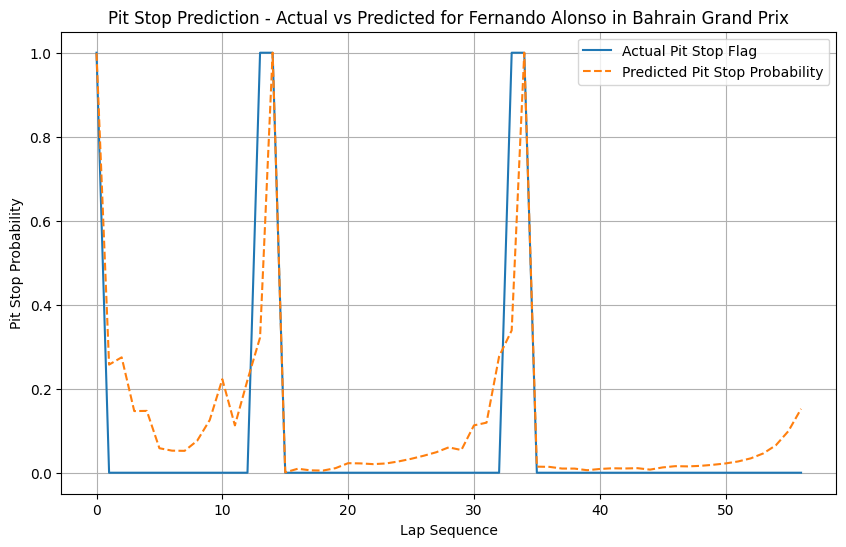

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")
# Load dataset
file_path = '/kaggle/input/2023-races/2023_races.csv'
data = pd.read_csv(file_path)

# Define columns to keep based on available data
columns_to_keep = ['Driver', 'LapNumber', 'Team', 'PitInTime', 'PitOutTime', 'Race_Venue', 'Compound', 'Position', 'TyreLife']
data_filtered = data[columns_to_keep]

# Handle missing Position data
data_filtered['Position'].replace('', np.nan, inplace=True)
data_filtered = data_filtered.groupby(['Race_Venue', 'Driver']).filter(lambda x: x['Position'].notna().all())

# Separate test data for Alonso in Bahrain
alonso_bahrain_data = data_filtered[(data_filtered['Driver'] == 'ALO') & (data_filtered['Race_Venue'] == 'Bahrain Grand Prix')]
train_data = data_filtered[~((data_filtered['Driver'] == 'ALO') & (data_filtered['Race_Venue'] == 'Bahrain Grand Prix'))]

# Convert pit times to seconds
time_columns = ['PitInTime', 'PitOutTime']
for col in time_columns:
    train_data[col] = pd.to_timedelta(train_data[col], errors='coerce').dt.total_seconds()
    alonso_bahrain_data[col] = pd.to_timedelta(alonso_bahrain_data[col], errors='coerce').dt.total_seconds()

# Feature engineering function
def calculate_race_features(df):
    if df.empty:
        return df  # Return empty DataFrame if no valid data

    # Determine the total number of laps in the race based on the maximum LapNumber
    total_laps = df['LapNumber'].max()

    # Check if the driver completed all laps
    driver_max_lap = df['LapNumber'].max()
    df['Crashed'] = 0  # Default: assume no crash
    if driver_max_lap < total_laps:  # If driver did not complete all laps in this race
        df['Crashed'] = 1  # Mark as crashed
    
    # Calculate RaceProgress, handling possible NaNs
    df['RaceProgress'] = df['LapNumber'] / total_laps
    df.dropna(subset=['RaceProgress'], inplace=True)

    if df.empty:
        return df  # Return if dropping NaNs results in an empty DataFrame

    # Normalize TyreLifeProgress
    df['TyreLifeProgress'] = MinMaxScaler((0, 1)).fit_transform(df[['TyreLife']].fillna(0))

    # Normalize Position
    df['Position'] = MinMaxScaler((0, 1)).fit_transform(df[['Position']])
    
    # Updated PitstopFlag logic: only set to 1 if both PitInTime and PitOutTime are non-null
    df['PitstopFlag'] = np.where((df['PitInTime'].notna()) | (df['PitOutTime'].notna()), 1, 0)
    return df


# Apply feature calculations
train_data = train_data.groupby(['Race_Venue', 'Driver']).apply(calculate_race_features).reset_index(drop=True)
alonso_bahrain_data = calculate_race_features(alonso_bahrain_data)

# One-hot encode categorical features for Compound
categorical_cols = ['Compound']
onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats_train = onehot.fit_transform(train_data[categorical_cols])
encoded_cats_bahrain = onehot.transform(alonso_bahrain_data[categorical_cols])

# Concatenate features
numerical_cols = ['LapNumber', 'RaceProgress', 'TyreLifeProgress', 'Position']
train_data_cleaned = np.concatenate([train_data[numerical_cols], encoded_cats_train], axis=1)

# Prepare sequences
race_sequences, labels = [], []
for _, race_data in train_data.groupby(['Race_Venue', 'Driver']):
    if not race_data.empty:
        race_data_combined = np.concatenate([race_data[numerical_cols].values, onehot.transform(race_data[categorical_cols])], axis=1)
        race_sequences.append(race_data_combined)
        labels.append(race_data['PitstopFlag'].values)

# Pad sequences for LSTM
X_padded = pad_sequences(race_sequences, dtype='float32', padding='post', value=0)
y_padded = pad_sequences(labels, dtype='float32', padding='post', value=0)

# Define model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(None, X_padded.shape[2])),
    Dropout(0.3),
    BatchNormalization(),
    Dense(64, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_padded, y_padded, epochs=20, batch_size=1, callbacks=[early_stopping])

# Prepare test data for Alonso in Bahrain
alonso_bahrain_encoded = np.concatenate([alonso_bahrain_data[numerical_cols].values, encoded_cats_bahrain], axis=1)
alonso_bahrain_padded = pad_sequences([alonso_bahrain_encoded], dtype='float32', padding='post', value=0)

# Make predictions
alonso_bahrain_predictions = model.predict(alonso_bahrain_padded)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(alonso_bahrain_data['PitstopFlag'].values, label='Actual Pit Stop Flag')
plt.plot(alonso_bahrain_predictions[0], label='Predicted Pit Stop Probability', linestyle='--')
plt.title("Pit Stop Prediction - Actual vs Predicted for Fernando Alonso in Bahrain Grand Prix")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend()
plt.grid(True)
plt.show()


In [1]:
file_path = '/kaggle/input/2023-races/2023_races.csv'
data = pd.read_csv(file_path)

# Define columns to keep based on available data
columns_to_keep = ['Driver', 'LapNumber', 'Team', 'PitInTime', 'PitOutTime', 'Race_Venue', 'Compound', 'Position', 'TyreLife']
data_filtered = data[columns_to_keep]

# Load Monaco data for Alonso (keeping the training data intact)
alonso_monaco_data = data_filtered[(data_filtered['Driver'] == 'PER') & (data_filtered['Race_Venue'] == 'Australian Grand Prix')]

# Convert pit times to seconds in Monaco data
for col in time_columns:
    alonso_monaco_data[col] = pd.to_timedelta(alonso_monaco_data[col], errors='coerce').dt.total_seconds()

# Apply feature calculations for Monaco data
alonso_monaco_data = calculate_race_features(alonso_monaco_data)

# One-hot encode categorical features for Compound in Monaco data
encoded_cats_monaco = onehot.transform(alonso_monaco_data[categorical_cols])

# Concatenate features for the Monaco race
alonso_monaco_encoded = np.concatenate([alonso_monaco_data[numerical_cols].values, encoded_cats_monaco], axis=1)
alonso_monaco_padded = pad_sequences([alonso_monaco_encoded], dtype='float32', padding='post', value=0)

# Make predictions using the already trained model
alonso_monaco_predictions = model.predict(alonso_monaco_padded)

# Plot results for Alonso in the Monaco Grand Prix
plt.figure(figsize=(10, 6))
plt.plot(alonso_monaco_data['PitstopFlag'].values, label='Actual Pit Stop Flag')
plt.plot(alonso_monaco_predictions[0], label='Predicted Pit Stop Probability', linestyle='--')
plt.title("Pit Stop Prediction - Actual vs Predicted for Fernando Alonso in Monaco Grand Prix")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'pd' is not defined

In [ ]:
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Suppress all warnings
warnings.filterwarnings("ignore")

# Load dataset
file_path = '/kaggle/input/2023-races/2023_races.csv'
data = pd.read_csv(file_path)

# Define columns to keep
columns_to_keep = ['Driver', 'LapNumber', 'Team', 'PitInTime', 'PitOutTime', 'Race_Venue', 'Compound', 'Position', 'TyreLife']
data_filtered = data[columns_to_keep]

# Handle missing Position data
data_filtered['Position'].replace('', np.nan, inplace=True)
data_filtered = data_filtered.groupby(['Race_Venue', 'Driver']).filter(lambda x: x['Position'].notna().all())

# Separate test data for Alonso in Monaco
alonso_monaco_data = data_filtered[(data_filtered['Driver'] == 'ALO') & (data_filtered['Race_Venue'] == 'Monaco Grand Prix')]
train_data = data_filtered[~((data_filtered['Driver'] == 'ALO') & (data_filtered['Race_Venue'] == 'Monaco Grand Prix'))]

# Convert pit times to seconds
time_columns = ['PitInTime', 'PitOutTime']
for col in time_columns:
    train_data[col] = pd.to_timedelta(train_data[col], errors='coerce').dt.total_seconds()
    alonso_monaco_data[col] = pd.to_timedelta(alonso_monaco_data[col], errors='coerce').dt.total_seconds()

# Feature engineering function
def calculate_race_features(df):
    if df.empty:
        return df  # Return empty DataFrame if no valid data

    df = df.sort_values(by='LapNumber').reset_index(drop=True)
    total_laps = df['LapNumber'].max()
    
    # Calculate RaceProgress
    df['RaceProgress'] = df['LapNumber'] / total_laps
    df.dropna(subset=['RaceProgress'], inplace=True)

    if df.empty:
        return df  # Return if dropping NaNs results in an empty DataFrame

    # Normalize TyreLifeProgress and Position
    df['TyreLifeProgress'] = MinMaxScaler((0, 1)).fit_transform(df[['TyreLife']].fillna(0))
    df['Position'] = MinMaxScaler((0, 1)).fit_transform(df[['Position']])
    
    # Set PitstopFlag to 1 if PitInTime or PitOutTime are present or if it's the first lap
    df['PitstopFlag'] = np.where((df['PitInTime'].notna()) | (df['PitOutTime'].notna()) | (df['LapNumber'] == 1), 1, 0)

    return df

# Apply feature calculations
train_data = train_data.groupby(['Race_Venue', 'Driver']).apply(calculate_race_features).reset_index(drop=True)
alonso_monaco_data = calculate_race_features(alonso_monaco_data)

# One-hot encode Compound as a separate target for multi-class classification
categorical_cols = ['Compound']
onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats_train = onehot.fit_transform(train_data[categorical_cols])
encoded_cats_monaco = onehot.transform(alonso_monaco_data[categorical_cols])

# Concatenate features
numerical_cols = ['LapNumber', 'RaceProgress', 'TyreLifeProgress', 'Position']
train_data_cleaned = np.concatenate([train_data[numerical_cols], encoded_cats_train], axis=1)

# Prepare sequences
race_sequences, pitstop_labels, compound_labels = [], [], []
for _, race_data in train_data.groupby(['Race_Venue', 'Driver']):
    if not race_data.empty:
        race_data_combined = np.concatenate([race_data[numerical_cols].values, onehot.transform(race_data[categorical_cols])], axis=1)
        race_sequences.append(race_data_combined)
        pitstop_labels.append(race_data['PitstopFlag'].values)
        compound_labels.append(onehot.transform(race_data[['Compound']]).tolist())  # Save as list for compatibility

# Pad sequences for LSTM
X_padded = pad_sequences(race_sequences, dtype='float32', padding='post', value=0)
y_pitstop_padded = pad_sequences(pitstop_labels, dtype='float32', padding='post', value=0)
y_compound_padded = pad_sequences(compound_labels, dtype='float32', padding='post', value=0)

# Define the LSTM model with multi-output structure
input_layer = Input(shape=(None, X_padded.shape[2]))

# Shared LSTM layers
x = LSTM(128, return_sequences=True)(input_layer)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Pitstop prediction output
pitstop_output = Dense(1, activation='sigmoid', name='PitstopFlag')(x)

# Compound prediction output, match number of unique classes
compound_output = Dense(encoded_cats_train.shape[1], activation='softmax', name='Compound')(x)

model = Model(inputs=input_layer, outputs=[pitstop_output, compound_output])

# Compile model with multiple losses
model.compile(optimizer=Adam(), 
              loss={'PitstopFlag': 'binary_crossentropy', 'Compound': 'categorical_crossentropy'},
              metrics={'PitstopFlag': 'accuracy', 'Compound': 'accuracy'})

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_padded, {'PitstopFlag': y_pitstop_padded, 'Compound': y_compound_padded}, 
                    epochs=20, batch_size=1, callbacks=[early_stopping])

# Prepare test data for Alonso in Monaco
alonso_monaco_encoded = np.concatenate([alonso_monaco_data[numerical_cols].values, encoded_cats_monaco], axis=1)
alonso_monaco_padded = pad_sequences([alonso_monaco_encoded], dtype='float32', padding='post', value=0)

# Make predictions
pitstop_predictions, compound_predictions = model.predict(alonso_monaco_padded)

# Plot pitstop probability with colored compound prediction
compound_colors = {0: 'blue', 1: 'yellow', 2: 'black'}  # Assume 0=soft, 1=medium, 2=hard
compound_indices = np.argmax(compound_predictions[0], axis=1)

plt.figure(figsize=(10, 6))
plt.plot(alonso_monaco_data['PitstopFlag'].values, label='Actual Pit Stop Flag')
plt.plot(pitstop_predictions[0], label='Predicted Pit Stop Probability', linestyle='--')

# Plot compound color changes at pit stops
for lap in range(len(pitstop_predictions[0])):
    if alonso_monaco_data.iloc[lap]['PitstopFlag'] == 1:
        plt.axvline(x=lap, color=compound_colors[compound_indices[lap]], linestyle='--', linewidth=1)

plt.title("Pit Stop Prediction with Tyre Compound for Alonso in Monaco Grand Prix")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Suppress all warnings
warnings.filterwarnings("ignore")

# Load dataset
file_path = '/kaggle/input/2023-races/2023_races.csv'
data = pd.read_csv(file_path)

# Define columns to keep
columns_to_keep = ['Driver', 'LapNumber', 'Team', 'PitInTime', 'PitOutTime', 'Race_Venue', 'Compound', 'Position', 'TyreLife']
data_filtered = data[columns_to_keep]

# Handle missing Position data
data_filtered['Position'].replace('', np.nan, inplace=True)
data_filtered = data_filtered.groupby(['Race_Venue', 'Driver']).filter(lambda x: x['Position'].notna().all())

# Separate test data for Alonso in Monaco
alonso_monaco_data = data_filtered[(data_filtered['Driver'] == 'ALO') & (data_filtered['Race_Venue'] == 'Monaco Grand Prix')]
train_data = data_filtered[~((data_filtered['Driver'] == 'ALO') & (data_filtered['Race_Venue'] == 'Monaco Grand Prix'))]

# Convert pit times to seconds
time_columns = ['PitInTime', 'PitOutTime']
for col in time_columns:
    train_data[col] = pd.to_timedelta(train_data[col], errors='coerce').dt.total_seconds()
    alonso_monaco_data[col] = pd.to_timedelta(alonso_monaco_data[col], errors='coerce').dt.total_seconds()

# Feature engineering function
def calculate_race_features(df):
    if df.empty:
        return df  # Return empty DataFrame if no valid data

    df = df.sort_values(by='LapNumber').reset_index(drop=True)
    total_laps = df['LapNumber'].max()
    
    # Calculate RaceProgress
    df['RaceProgress'] = df['LapNumber'] / total_laps
    df.dropna(subset=['RaceProgress'], inplace=True)

    if df.empty:
        return df  # Return if dropping NaNs results in an empty DataFrame

    # Normalize TyreLifeProgress and Position (but we won't use TyreLifeProgress for predictions)
    df['TyreLifeProgress'] = MinMaxScaler((0, 1)).fit_transform(df[['TyreLife']].fillna(0))
    df['Position'] = MinMaxScaler((0, 1)).fit_transform(df[['Position']])
    
    # Set PitstopFlag to 1 if PitInTime or PitOutTime are present or if it's the first lap
    df['PitstopFlag'] = np.where((df['PitInTime'].notna()) | (df['PitOutTime'].notna()) | (df['LapNumber'] == 1), 1, 0)

    return df

# Apply feature calculations
train_data = train_data.groupby(['Race_Venue', 'Driver']).apply(calculate_race_features).reset_index(drop=True)
alonso_monaco_data = calculate_race_features(alonso_monaco_data)

# One-hot encode Compound as a separate target for multi-class classification (Now including all 5 types)
compound_categories = ['Soft', 'Medium', 'Hard', 'Intermediate', 'Wet']
data_filtered['Compound'] = pd.Categorical(data_filtered['Compound'], categories=compound_categories)
categorical_cols = ['Compound']
onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats_train = onehot.fit_transform(train_data[categorical_cols])
encoded_cats_monaco = onehot.transform(alonso_monaco_data[categorical_cols])

# Concatenate features
numerical_cols = ['LapNumber', 'RaceProgress', 'TyreLifeProgress', 'Position']
train_data_cleaned = np.concatenate([train_data[numerical_cols], encoded_cats_train], axis=1)

# Prepare sequences
race_sequences, pitstop_labels, compound_labels = [], [], []
for _, race_data in train_data.groupby(['Race_Venue', 'Driver']):
    if not race_data.empty:
        race_data_combined = np.concatenate([race_data[numerical_cols].values, onehot.transform(race_data[categorical_cols])], axis=1)
        race_sequences.append(race_data_combined)
        pitstop_labels.append(race_data['PitstopFlag'].values)
        compound_labels.append(onehot.transform(race_data[['Compound']]).tolist())  # Save as list for compatibility

# Pad sequences for LSTM
X_padded = pad_sequences(race_sequences, dtype='float32', padding='post', value=0)
y_pitstop_padded = pad_sequences(pitstop_labels, dtype='float32', padding='post', value=0)
y_compound_padded = pad_sequences(compound_labels, dtype='float32', padding='post', value=0)

# Define the LSTM model with multi-output structure
input_layer = Input(shape=(None, X_padded.shape[2]))

# Shared LSTM layers
x = LSTM(128, return_sequences=True)(input_layer)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Pitstop prediction output
pitstop_output = Dense(1, activation='sigmoid', name='PitstopFlag')(x)

# Compound prediction output, match number of unique classes (now 5 compounds)
compound_output = Dense(encoded_cats_train.shape[1], activation='softmax', name='Compound')(x)

model = Model(inputs=input_layer, outputs=[pitstop_output, compound_output])

# Compile model with multiple losses
model.compile(optimizer=Adam(), 
              loss={'PitstopFlag': 'binary_crossentropy', 'Compound': 'categorical_crossentropy'},
              metrics={'PitstopFlag': 'accuracy', 'Compound': 'accuracy'})

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_padded, {'PitstopFlag': y_pitstop_padded, 'Compound': y_compound_padded}, 
                    epochs=20, batch_size=1, callbacks=[early_stopping])

# Prepare test data for Alonso in Monaco
alonso_monaco_encoded = np.concatenate([alonso_monaco_data[numerical_cols].values, encoded_cats_monaco], axis=1)
alonso_monaco_padded = pad_sequences([alonso_monaco_encoded], dtype='float32', padding='post', value=0)

# Make predictions
pitstop_predictions, compound_predictions = model.predict(alonso_monaco_padded)

# Plot pitstop probability with colored compound prediction
compound_colors = {0: 'blue', 1: 'yellow', 2: 'black', 3: 'green', 4: 'gray'}  # 0=soft, 1=medium, 2=hard, 3=intermediate, 4=wet
compound_indices = np.argmax(compound_predictions[0], axis=1)

# Plot pitstop probability line with colored segments
plt.figure(figsize=(10, 6))

# Loop through each lap and plot the prediction with the respective color
for i in range(1, len(pitstop_predictions[0])):
    start = i - 1
    end = i
    # Get the color based on the predicted compound
    color = compound_colors[compound_indices[start]]
    plt.plot([start, end], [pitstop_predictions[0][start], pitstop_predictions[0][end]], color=color, lw=2)

plt.plot(alonso_monaco_data['PitstopFlag'].values, label='Actual Pit Stop Flag', color='black', linewidth=2)
plt.title("Pit Stop Prediction with Colored Tyre Compound for Alonso in Monaco Grand Prix")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Suppress warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

# Load dataset
file_path = '/kaggle/input/2023-races/2023_races.csv'
data = pd.read_csv(file_path)

# Define columns to keep
columns_to_keep = ['Driver', 'LapNumber', 'Team', 'PitInTime', 'PitOutTime', 'Race_Venue', 'Compound', 'Position', 'TyreLife']
data_filtered = data[columns_to_keep]

# Handle missing Position data
data_filtered['Position'].replace('', np.nan, inplace=True)
data_filtered = data_filtered.groupby(['Race_Venue', 'Driver']).filter(lambda x: x['Position'].notna().all())

# Separate test data for Alonso in Monaco
alonso_monaco_data = data_filtered[(data_filtered['Driver'] == 'ALO') & (data_filtered['Race_Venue'] == 'Bahrain Grand Prix')]
train_data = data_filtered[~((data_filtered['Driver'] == 'ALO') & (data_filtered['Race_Venue'] == 'Bahrain Grand Prix'))]

# Convert pit times to seconds
time_columns = ['PitInTime', 'PitOutTime']
for col in time_columns:
    train_data[col] = pd.to_timedelta(train_data[col], errors='coerce').dt.total_seconds()
    alonso_monaco_data[col] = pd.to_timedelta(alonso_monaco_data[col], errors='coerce').dt.total_seconds()

# Feature engineering function
def calculate_race_features(df):
    if df.empty:
        return df

    df = df.sort_values(by='LapNumber').reset_index(drop=True)
    total_laps = df['LapNumber'].max()
    
    # Calculate RaceProgress
    df['RaceProgress'] = df['LapNumber'] / total_laps
    df.dropna(subset=['RaceProgress'], inplace=True)

    if df.empty:
        return df

    # Normalize TyreLifeProgress and Position
    df['TyreLifeProgress'] = MinMaxScaler((0, 1)).fit_transform(df[['TyreLife']].fillna(0))
    df['Position'] = MinMaxScaler((0, 1)).fit_transform(df[['Position']])
    
    # Set PitstopFlag to 1 if PitInTime or PitOutTime are present or if it's the first lap
    df['PitstopFlag'] = np.where((df['PitInTime'].notna()) | (df['PitOutTime'].notna()) | (df['LapNumber'] == 1), 1, 0)

    return df

# Apply feature calculations
train_data = train_data.groupby(['Race_Venue', 'Driver']).apply(calculate_race_features).reset_index(drop=True)
alonso_monaco_data = calculate_race_features(alonso_monaco_data)

# One-hot encode Compound as a separate target for multi-class classification
compound_categories = ['Soft', 'Medium', 'Hard', 'Intermediate', 'Wet']
data_filtered['Compound'] = pd.Categorical(data_filtered['Compound'], categories=compound_categories)
categorical_cols = ['Compound']
onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats_train = onehot.fit_transform(train_data[categorical_cols])
encoded_cats_monaco = onehot.transform(alonso_monaco_data[categorical_cols])

# Concatenate features
numerical_cols = ['LapNumber', 'RaceProgress', 'TyreLifeProgress', 'Position']
train_data_cleaned = np.concatenate([train_data[numerical_cols], encoded_cats_train], axis=1)

# Prepare sequences
race_sequences, pitstop_labels, compound_labels = [], [], []
for _, race_data in train_data.groupby(['Race_Venue', 'Driver']):
    if not race_data.empty:
        race_data_combined = np.concatenate([race_data[numerical_cols].values, onehot.transform(race_data[categorical_cols])], axis=1)
        race_sequences.append(race_data_combined)
        pitstop_labels.append(race_data['PitstopFlag'].values)
        compound_labels.append(onehot.transform(race_data[['Compound']]).tolist())

# Pad sequences for LSTM
X_padded = pad_sequences(race_sequences, dtype='float32', padding='post', value=0)
y_pitstop_padded = pad_sequences(pitstop_labels, dtype='float32', padding='post', value=0)
y_compound_padded = pad_sequences(compound_labels, dtype='float32', padding='post', value=0)

# Pit Stop Prediction Model with Class Weights
pitstop_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(None, X_padded.shape[2])),
    Dropout(0.3),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
pitstop_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Class weights for pitstop prediction
class_weights = {0: 0.5, 1: 5.0}
pitstop_model.fit(X_padded, y_pitstop_padded, epochs=20, batch_size=1, callbacks=[early_stopping], class_weight=class_weights)

# Compound Prediction Model
compound_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(None, X_padded.shape[2])),
    Dropout(0.3),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(encoded_cats_train.shape[1], activation='softmax')
])
compound_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
compound_model.fit(X_padded, y_compound_padded, epochs=20, batch_size=1, callbacks=[early_stopping])

# Prepare test data for Alonso in Monaco
alonso_monaco_encoded = np.concatenate([alonso_monaco_data[numerical_cols].values, encoded_cats_monaco], axis=1)
alonso_monaco_padded = pad_sequences([alonso_monaco_encoded], dtype='float32', padding='post', value=0)

# Make predictions with separate models
pitstop_predictions = pitstop_model.predict(alonso_monaco_padded)
compound_predictions = compound_model.predict(alonso_monaco_padded)

# Plot pitstop probability with colored compound prediction
compound_colors = {0: 'blue', 1: 'yellow', 2: 'black', 3: 'green', 4: 'gray'}
compound_indices = np.argmax(compound_predictions[0], axis=1)

plt.figure(figsize=(10, 6))
for i in range(1, len(pitstop_predictions[0])):
    start = i - 1
    end = i
    color = compound_colors[compound_indices[start]]
    plt.plot([start, end], [pitstop_predictions[0][start], pitstop_predictions[0][end]], color=color, lw=2)

plt.plot(alonso_monaco_data['PitstopFlag'].values, label='Actual Pit Stop Flag', color='black', linewidth=2)
plt.title("Pit Stop Prediction with Colored Tyre Compound for Alonso in Monaco Grand Prix")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


In [ ]:
file_path = '/kaggle/input/2023-races/2023_races.csv'
data = pd.read_csv(file_path)

# Define columns to keep
columns_to_keep = ['Driver', 'LapTime','LapNumber', 'Team', 'PitInTime', 'PitOutTime', 'Race_Venue', 'Compound', 'Position', 'TyreLife']
data_filtered = data[columns_to_keep]

# Drop rows with missing LapTime values
sai_italian_gp_data = data_filtered[(data_filtered['Driver'] == 'SAI') & (data_filtered['Race_Venue'] == 'Italian Grand Prix')]

# Drop rows where 'LapTime' is NaN or missing
sai_italian_gp_data = sai_italian_gp_data.dropna(subset=['LapTime'])

# Ensure that data is not empty after dropping rows
if sai_italian_gp_data.empty:
    print("No data available for SAI in the Italian Grand Prix after dropping rows with missing LapTime.")
else:
    # Apply feature engineering and sequence preparation for the test data (SAI in Italian GP)
    sai_italian_gp_data = calculate_race_features(sai_italian_gp_data)

    # One-hot encode Compound for the new test data (SAI in Italian GP)
    encoded_cats_sai_italian_gp = onehot.transform(sai_italian_gp_data[['Compound']])

    # Prepare test data for SAI in Italian GP
    sai_italian_gp_encoded = np.concatenate([sai_italian_gp_data[numerical_cols].values, encoded_cats_sai_italian_gp], axis=1)
    sai_italian_gp_padded = pad_sequences([sai_italian_gp_encoded], dtype='float32', padding='post', value=0)

    # Make predictions for pit stops and tire compounds using the existing models
    pitstop_predictions_sai = pitstop_model.predict(sai_italian_gp_padded)
    compound_predictions_sai = compound_model.predict(sai_italian_gp_padded)

    # Plot pitstop probability with colored compound prediction for SAI in Italian Grand Prix
    compound_colors = {0: 'blue', 1: 'yellow', 2: 'black', 3: 'green', 4: 'gray'}
    compound_indices_sai = np.argmax(compound_predictions_sai[0], axis=1)

    # Plot actual vs predicted pit stop probabilities
    plt.figure(figsize=(10, 6))
    for i in range(1, len(pitstop_predictions_sai[0])):
        start = i - 1
        end = i
        color = compound_colors[compound_indices_sai[start]]
        plt.plot([start, end], [pitstop_predictions_sai[0][start], pitstop_predictions_sai[0][end]], color=color, lw=2)

    # Actual pit stop flags (assuming actual values are available)
    #plt.plot(sai_italian_gp_data['PitstopFlag'].values, label='Actual Pit Stop Flag', color='black', linewidth=2)

    # Adding legend for compound colors
    compound_labels = ['Soft', 'Medium', 'Hard', 'Intermediate', 'Wet']
    handles = [plt.Line2D([0], [0], color=color, lw=2) for color in compound_colors.values()]
    plt.legend(handles=handles, labels=compound_labels, title="Tire Compound", loc="upper right")

    # Customize plot
    plt.title("Pit Stop Prediction with Colored Tyre Compound for SAI in Italian Grand Prix")
    plt.xlabel("Lap Sequence")
    plt.ylabel("Pit Stop Probability")
    plt.grid(True)
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Suppress warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

# Load dataset
file_path = '/kaggle/input/2023-races/2023_races.csv'
data = pd.read_csv(file_path)

# Define columns to keep
columns_to_keep = ['Driver', 'LapNumber', 'Team', 'PitInTime', 'PitOutTime', 'Race_Venue', 'Compound', 'Position', 'TyreLife', 'LapTime']
data_filtered = data[columns_to_keep]

# Handle missing Position data
data_filtered['Position'].replace('', np.nan, inplace=True)
data_filtered = data_filtered.groupby(['Race_Venue', 'Driver']).filter(lambda x: x['Position'].notna().all())

# Separate test data for Alonso in Bahrain (example)
alonso_bahrain_data = data_filtered[(data_filtered['Driver'] == 'ALO') & (data_filtered['Race_Venue'] == 'Bahrain Grand Prix')]
train_data = data_filtered[~((data_filtered['Driver'] == 'ALO') & (data_filtered['Race_Venue'] == 'Bahrain Grand Prix'))]

# Convert pit times to seconds
time_columns = ['PitInTime', 'PitOutTime']
for col in time_columns:
    train_data[col] = pd.to_timedelta(train_data[col], errors='coerce').dt.total_seconds()
    alonso_bahrain_data[col] = pd.to_timedelta(alonso_bahrain_data[col], errors='coerce').dt.total_seconds()

# Feature engineering function
def calculate_race_features(df):
    if df.empty:
        return df

    df = df.sort_values(by='LapNumber').reset_index(drop=True)
    total_laps = df['LapNumber'].max()

    # Calculate RaceProgress
    df['RaceProgress'] = df['LapNumber'] / total_laps
    df.dropna(subset=['RaceProgress'], inplace=True)

    if df.empty:
        return df

    # Normalize TyreLifeProgress and Position
    df['TyreLifeProgress'] = MinMaxScaler((0, 1)).fit_transform(df[['TyreLife']].fillna(0))
    df['Position'] = MinMaxScaler((0, 1)).fit_transform(df[['Position']])

    # Use existing LapTime data
    df['LapTime'] = df['LapTime']  # Ensure LapTime is directly used from the dataset
    df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce').dt.total_seconds()

    # Set PitstopFlag to 1 if PitInTime or PitOutTime are present or if it's the first lap
    df['PitstopFlag'] = np.where((df['PitInTime'].notna()) | (df['PitOutTime'].notna()) | (df['LapNumber'] == 1), 1, 0)

    # Adjust TyreLifeProgress based on LapTime and reset on pit stop
    df['AdjustedTyreLife'] = df['TyreLifeProgress'].copy()
    for i in range(1, len(df)):
        if df['PitstopFlag'].iloc[i] == 1:
            df['AdjustedTyreLife'].iloc[i] = 0  # Reset tire life after pit stop
        else:
            df['AdjustedTyreLife'].iloc[i] = df['AdjustedTyreLife'].iloc[i-1] - (df['LapTime'].iloc[i] * 0.01)  # Example degradation

    return df

# Apply feature calculations
train_data = train_data.groupby(['Race_Venue', 'Driver']).apply(calculate_race_features).reset_index(drop=True)
alonso_bahrain_data = calculate_race_features(alonso_bahrain_data)

# One-hot encode Compound as a separate target for multi-class classification
compound_categories = ['Soft', 'Medium', 'Hard', 'Intermediate', 'Wet']
data_filtered['Compound'] = pd.Categorical(data_filtered['Compound'], categories=compound_categories)
categorical_cols = ['Compound']
onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats_train = onehot.fit_transform(train_data[categorical_cols])
encoded_cats_bahrain = onehot.transform(alonso_bahrain_data[categorical_cols])

# Concatenate features
numerical_cols = ['LapNumber', 'RaceProgress', 'AdjustedTyreLife', 'Position', 'LapTime']
train_data_cleaned = np.concatenate([train_data[numerical_cols], encoded_cats_train], axis=1)

# Prepare sequences
race_sequences, pitstop_labels, compound_labels = [], [], []
for _, race_data in train_data.groupby(['Race_Venue', 'Driver']):
    if not race_data.empty:
        race_data_combined = np.concatenate([race_data[numerical_cols].values, onehot.transform(race_data[categorical_cols])], axis=1)
        race_sequences.append(race_data_combined)
        pitstop_labels.append(race_data['PitstopFlag'].values)
        compound_labels.append(onehot.transform(race_data[['Compound']]).tolist())

# Pad sequences for LSTM
X_padded = pad_sequences(race_sequences, dtype='float32', padding='post', value=0)
y_pitstop_padded = pad_sequences(pitstop_labels, dtype='float32', padding='post', value=0)
y_compound_padded = pad_sequences(compound_labels, dtype='float32', padding='post', value=0)

# Pit Stop Prediction Model with Class Weights
pitstop_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(None, X_padded.shape[2])),
    Dropout(0.3),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
pitstop_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Class weights for pitstop prediction
class_weights = {0: 0.5, 1: 5.0}
pitstop_model.fit(X_padded, y_pitstop_padded, epochs=20, batch_size=1, callbacks=[early_stopping], class_weight=class_weights)

# Compound Prediction Model
compound_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(None, X_padded.shape[2])),
    Dropout(0.3),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(encoded_cats_train.shape[1], activation='softmax')
])
compound_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
compound_model.fit(X_padded, y_compound_padded, epochs=20, batch_size=1, callbacks=[early_stopping])

# Prepare test data for Alonso in Bahrain
alonso_bahrain_encoded = np.concatenate([alonso_bahrain_data[numerical_cols].values, encoded_cats_bahrain], axis=1)
alonso_bahrain_padded = pad_sequences([alonso_bahrain_encoded], dtype='float32', padding='post', value=0)

# Make predictions with separate models
pitstop_predictions = pitstop_model.predict(alonso_bahrain_padded)
compound_predictions = compound_model.predict(alonso_bahrain_padded)

# Plot pitstop probability with colored compound prediction
compound_colors = {0: 'blue', 1: 'yellow', 2: 'black', 3: 'green', 4: 'gray'}
compound_indices = np.argmax(compound_predictions[0], axis=1)

plt.figure(figsize=(10, 6))
for i in range(1, len(pitstop_predictions[0])):
    start = i - 1
    end = i
    color = compound_colors[compound_indices[start]]
    plt.plot([start, end], [pitstop_predictions[0][start], pitstop_predictions[0][end]], color=color, lw=2)

plt.plot(alonso_bahrain_data['PitstopFlag'].values, label='Actual Pit Stop Flag', color='black', linewidth=2)
plt.title("Pit Stop Prediction with Colored Tyre Compound for Alonso in Bahrain Grand Prix")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


Compound Model Accuracy: 0.81
Epoch 1/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.7943 - loss: 0.2227
Epoch 2/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.9583 - loss: 0.0676
Epoch 3/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.9687 - loss: 0.0542
Epoch 4/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9708 - loss: 0.0494
Epoch 5/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.9716 - loss: 0.0484
Epoch 6/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9711 - loss: 0.0461
Epoch 7/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.9744 - loss: 0.0422
Epoch 8/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.9737 - loss: 0.0432
Epoch 9/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.9738 - loss: 0.0420
Epoch 10/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.9733 - loss: 0.0420
Epoch 11/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9745 - loss: 0.0396


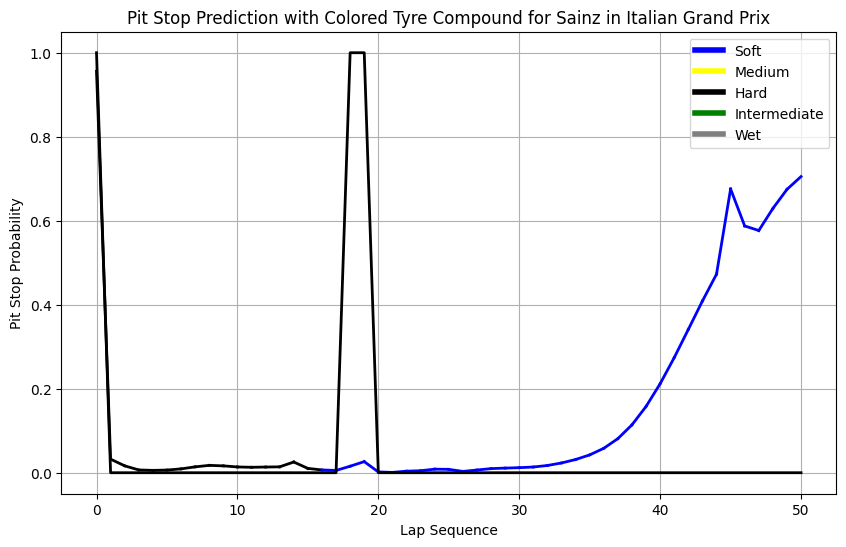

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Load dataset
file_path = '/kaggle/input/2023-races/2023_races.csv'
data = pd.read_csv(file_path)

# Define columns to keep
columns_to_keep = ['Driver', 'LapNumber', 'Team', 'PitInTime', 'PitOutTime', 'Race_Venue', 'Compound', 'Position', 'TyreLife', 'LapTime']
data_filtered = data[columns_to_keep]
data_filtered = data.dropna(subset=['LapTime'])
# Convert LapTime, PitInTime, and PitOutTime columns to total seconds
time_columns = ['LapTime', 'PitInTime', 'PitOutTime']
for col in time_columns:
    data_filtered[col] = pd.to_timedelta(data_filtered[col], errors='coerce').dt.total_seconds()

# Handle missing Position data
data_filtered['Position'].replace('', np.nan, inplace=True)
data_filtered = data_filtered.groupby(['Race_Venue', 'Driver']).filter(lambda x: x['Position'].notna().all())

# Feature engineering function for compound and pit stop
# Feature engineering function with checks for NaN values
def calculate_race_features(df):
    if df.empty:
        return df  # Return empty DataFrame if no valid data

    df = df.sort_values(by='LapNumber').reset_index(drop=True)
    total_laps = df['LapNumber'].max()
    
    # Calculate RaceProgress
    df['RaceProgress'] = df['LapNumber'] / total_laps
    df.dropna(subset=['RaceProgress'], inplace=True)

    if df.empty:
        return df  # Return if dropping NaNs results in an empty DataFrame

    # Normalize TyreLifeProgress
    if df['TyreLife'].notna().any():
        df['TyreLifeProgress'] = MinMaxScaler((0, 1)).fit_transform(df[['TyreLife']].fillna(0))
    else:
        df['TyreLifeProgress'] = 0  # Set to 0 if all values are NaN

    # Normalize Position
    if df['Position'].notna().any():
        df['Position'] = MinMaxScaler((0, 1)).fit_transform(df[['Position']].fillna(0))
    else:
        df['Position'] = 0  # Set to 0 if all values are NaN
    
    # Set PitstopFlag to 1 if PitInTime or PitOutTime are present or if it's the first lap
    df['PitstopFlag'] = np.where((df['PitInTime'].notna()) | (df['PitOutTime'].notna()) | (df['LapNumber'] == 1), 1, 0)

    return df


# Apply feature engineering
data_filtered = data_filtered.groupby(['Race_Venue', 'Driver']).apply(calculate_race_features).reset_index(drop=True)

# Label encode 'Compound' to ensure consistency
compound_encoder = LabelEncoder()
data_filtered['Compound'] = compound_encoder.fit_transform(data_filtered['Compound'])

# Create OptimalCompound based on pit stops
data_filtered['OptimalCompound'] = data_filtered.apply(lambda row: row['Compound'] if row['PitstopFlag'] == 1 else np.nan, axis=1)

# Fill NaN values in 'OptimalCompound' with -1 for missing entries, then convert to integer
data_filtered['OptimalCompound'] = data_filtered['OptimalCompound'].fillna(-1).astype(int)

# Prepare the Compound Choice Model dataset
compound_data = data_filtered[['LapTime', 'TyreLifeProgress', 'RaceProgress', 'Position', 'Compound']].dropna()
X_compound = compound_data[['LapTime', 'TyreLifeProgress', 'RaceProgress', 'Position']]
y_compound = compound_data['Compound']
X_train_comp, X_test_comp, y_train_comp, y_test_comp = train_test_split(X_compound, y_compound, test_size=0.2, random_state=42)

# Train Compound Choice Model
compound_model = RandomForestClassifier()
compound_model.fit(X_train_comp, y_train_comp)
compound_accuracy = compound_model.score(X_test_comp, y_test_comp)
print(f"Compound Model Accuracy: {compound_accuracy:.2f}")

# Prepare the Pit Stop Model dataset
race_sequences, pitstop_labels = [], []
for _, race_data in data_filtered.groupby(['Race_Venue', 'Driver']):
    race_sequences.append(race_data[['LapNumber', 'TyreLifeProgress', 'RaceProgress', 'Position']].values)
    pitstop_labels.append(race_data['PitstopFlag'].values)

X_pitstop = pad_sequences(race_sequences, dtype='float32', padding='post', value=0)
y_pitstop = pad_sequences(pitstop_labels, dtype='float32', padding='post', value=0)

# Define Pit Stop Model with class weights
class_weights = {0: 0.5, 1: 5.0}  # Adjusted to emphasize pit stops
input_layer = Input(shape=(None, X_pitstop.shape[2]))

x = LSTM(128, return_sequences=True)(input_layer)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
pitstop_output = Dense(1, activation='sigmoid', name='PitstopFlag')(x)

pitstop_model = Model(inputs=input_layer, outputs=pitstop_output)
pitstop_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
history = pitstop_model.fit(X_pitstop, y_pitstop, epochs=20, batch_size=1, callbacks=[early_stopping], class_weight=class_weights)

# Testing and plotting for a specific race and driver, e.g., SAI in Italian Grand Prix
sainz_data = data_filtered[(data_filtered['Driver'] == 'SAI') & (data_filtered['Race_Venue'] == 'Italian Grand Prix')]

# Apply the feature engineering on sainz_data
sainz_data = calculate_race_features(sainz_data)
sainz_encoded = np.concatenate([sainz_data[['LapNumber', 'RaceProgress', 'TyreLifeProgress', 'Position']].values], axis=1)
sainz_padded = pad_sequences([sainz_encoded], dtype='float32', padding='post', value=0)

# Make predictions
pitstop_predictions = pitstop_model.predict(sainz_padded)

# Make compound predictions for plotting
compound_indices = compound_model.predict(X_compound)  # Directly use the class predictions

# Define colors for compounds
compound_colors = {0: 'blue', 1: 'yellow', 2: 'black', 3: 'green', 4: 'gray'}  # 0=soft, 1=medium, 2=hard, 3=intermediate, 4=wet

# Plot pit stop probability with colored compound prediction
plt.figure(figsize=(10, 6))

# Plot prediction with colored segments
for lap in range(1, len(pitstop_predictions[0])):
    start = lap - 1
    end = lap
    color = compound_colors[compound_indices[start]]
    plt.plot([start, end], [pitstop_predictions[0][start], pitstop_predictions[0][end]], color=color, lw=2)

plt.plot(sainz_data['PitstopFlag'].values, label='Actual Pit Stop Flag', color='black', linewidth=2)
plt.title("Pit Stop Prediction with Colored Tyre Compound for Sainz in Italian Grand Prix")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend(handles=[plt.Line2D([0], [0], color='blue', lw=4, label='Soft'),
                    plt.Line2D([0], [0], color='yellow', lw=4, label='Medium'),
                    plt.Line2D([0], [0], color='black', lw=4, label='Hard'),
                    plt.Line2D([0], [0], color='green', lw=4, label='Intermediate'),
                    plt.Line2D([0], [0], color='gray', lw=4, label='Wet')])
plt.grid(True)
plt.show()



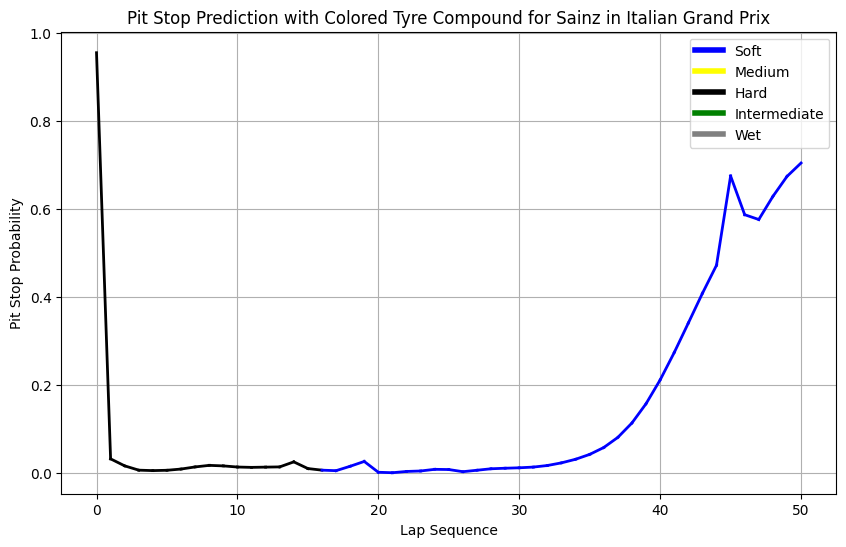

In [5]:
# Plot pit stop probability with colored compound prediction
plt.figure(figsize=(10, 6))

# Plot prediction with colored segments
for lap in range(1, len(pitstop_predictions[0])):
    start = lap - 1
    end = lap
    color = compound_colors[compound_indices[start]]
    plt.plot([start, end], [pitstop_predictions[0][start], pitstop_predictions[0][end]], color=color, lw=2)

#plt.plot(sainz_data['PitstopFlag'].values, label='Actual Pit Stop Flag', color='black', linewidth=2)
plt.title("Pit Stop Prediction with Colored Tyre Compound for Sainz in Italian Grand Prix")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend(handles=[plt.Line2D([0], [0], color='blue', lw=4, label='Soft'),
                    plt.Line2D([0], [0], color='yellow', lw=4, label='Medium'),
                    plt.Line2D([0], [0], color='black', lw=4, label='Hard'),
                    plt.Line2D([0], [0], color='green', lw=4, label='Intermediate'),
                    plt.Line2D([0], [0], color='gray', lw=4, label='Wet')])
plt.grid(True)
plt.show()


Epoch 1/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.7936 - loss: 0.2225
Epoch 2/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9544 - loss: 0.0811
Epoch 3/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.9603 - loss: 0.0709
Epoch 4/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.9662 - loss: 0.0636
Epoch 5/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.9628 - loss: 0.0680
Epoch 6/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.9650 - loss: 0.0621
Epoch 7/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9646 - loss: 0.0637
Epoch 8/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.9661 - loss: 0.0612
Epoch 9/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.9647 - loss: 0.0627
Epoch 10/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.9671 - loss: 0.0605
Epoch 11/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.9660 - loss: 0.0598
Epoch 12/20
410/410 ━━━━━━━━━━

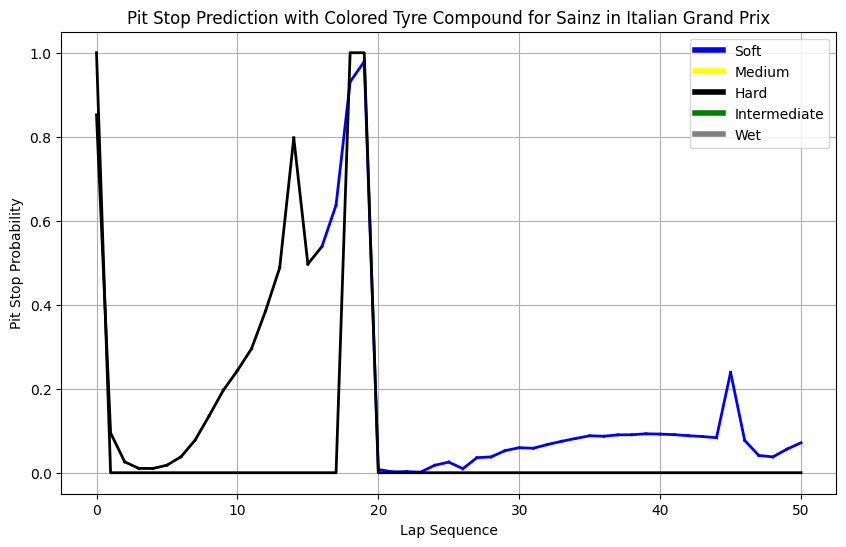

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Load dataset
file_path = '/kaggle/input/2023-races/2023_races.csv'
data = pd.read_csv(file_path)

# Define columns to keep
columns_to_keep = ['Driver', 'LapNumber', 'Team', 'PitInTime', 'PitOutTime', 'Race_Venue', 'Compound', 'Position', 'TyreLife', 'LapTime']
data_filtered = data[columns_to_keep]
data_filtered = data_filtered.dropna(subset=['LapTime'])  # Remove rows with missing LapTimes

# Convert time columns to seconds
time_columns = ['LapTime', 'PitInTime', 'PitOutTime']
for col in time_columns:
    data_filtered[col] = pd.to_timedelta(data_filtered[col], errors='coerce').dt.total_seconds()

# Handle missing Position data
data_filtered['Position'].replace('', np.nan, inplace=True)
data_filtered = data_filtered.groupby(['Race_Venue', 'Driver']).filter(lambda x: x['Position'].notna().all())

# Function to simulate tyre degradation and reset on pit stops
def calculate_race_features(df):
    if df.empty:
        return df  # Return empty DataFrame if no valid data

    df = df.sort_values(by='LapNumber').reset_index(drop=True)
    total_laps = df['LapNumber'].max()
    
    # Track RaceProgress
    df['RaceProgress'] = df['LapNumber'] / total_laps

    # Reset tyre life on each pit stop and apply tyre degradation
    df['TyreLifeProgress'] = 1.0  # Initialize full tyre life for new tyres
    degradation_rate = 1.0 / 20  # Adjust degradation rate as needed
    
    for i in range(1, len(df)):
        if df.loc[i, 'PitInTime'] or df.loc[i, 'PitOutTime']:
            df.loc[i, 'TyreLifeProgress'] = 1.0  # Reset on pit stop
        else:
            df.loc[i, 'TyreLifeProgress'] = max(0, df.loc[i-1, 'TyreLifeProgress'] - degradation_rate)  # Degrade

    # Normalize Position and set PitstopFlag
    if df['Position'].notna().any():
        df['Position'] = MinMaxScaler((0, 1)).fit_transform(df[['Position']].fillna(0))
    else:
        df['Position'] = 0  # Set to 0 if all values are NaN
    
    df['PitstopFlag'] = np.where((df['PitInTime'].notna()) | (df['PitOutTime'].notna()) | (df['LapNumber'] == 1), 1, 0)

    return df

# Apply feature engineering
data_filtered = data_filtered.groupby(['Race_Venue', 'Driver']).apply(calculate_race_features).reset_index(drop=True)

# Label encode 'Compound' and prepare compound choice model dataset
compound_encoder = LabelEncoder()
data_filtered['Compound'] = compound_encoder.fit_transform(data_filtered['Compound'])
data_filtered['OptimalCompound'] = data_filtered.apply(lambda row: row['Compound'] if row['PitstopFlag'] == 1 else np.nan, axis=1)
data_filtered['OptimalCompound'] = data_filtered['OptimalCompound'].fillna(-1).astype(int)

# Prepare dataset for Compound Choice Model
compound_data = data_filtered[['LapTime', 'TyreLifeProgress', 'RaceProgress', 'Position', 'Compound']].dropna()
X_compound = compound_data[['LapTime', 'TyreLifeProgress', 'RaceProgress', 'Position']]
y_compound = compound_data['Compound']
X_train_comp, X_test_comp, y_train_comp, y_test_comp = train_test_split(X_compound, y_compound, test_size=0.2, random_state=42)

# Train Compound Choice Model
compound_model = RandomForestClassifier()
compound_model.fit(X_train_comp, y_train_comp)

# Prepare Pit Stop Model dataset
race_sequences, pitstop_labels = [], []
for _, race_data in data_filtered.groupby(['Race_Venue', 'Driver']):
    race_sequences.append(race_data[['LapNumber', 'TyreLifeProgress', 'RaceProgress', 'Position']].values)
    pitstop_labels.append(race_data['PitstopFlag'].values)

X_pitstop = pad_sequences(race_sequences, dtype='float32', padding='post', value=0)
y_pitstop = pad_sequences(pitstop_labels, dtype='float32', padding='post', value=0)

# Define and compile Pit Stop Model
class_weights = {0: 0.5, 1: 5.0}
input_layer = Input(shape=(None, X_pitstop.shape[2]))
x = LSTM(128, return_sequences=True)(input_layer)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
pitstop_output = Dense(1, activation='sigmoid', name='PitstopFlag')(x)

pitstop_model = Model(inputs=input_layer, outputs=pitstop_output)
pitstop_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
pitstop_model.fit(X_pitstop, y_pitstop, epochs=20, batch_size=1, callbacks=[early_stopping], class_weight=class_weights)

# Predict for a specific race, e.g., SAI in Italian Grand Prix
sainz_data = data_filtered[(data_filtered['Driver'] == 'SAI') & (data_filtered['Race_Venue'] == 'Italian Grand Prix')]
sainz_data = calculate_race_features(sainz_data)
sainz_encoded = np.concatenate([sainz_data[['LapNumber', 'RaceProgress', 'TyreLifeProgress', 'Position']].values], axis=1)
sainz_padded = pad_sequences([sainz_encoded], dtype='float32', padding='post', value=0)

pitstop_predictions = pitstop_model.predict(sainz_padded)

# Plotting pit stop probability with colored compound prediction
compound_colors = {0: 'blue', 1: 'yellow', 2: 'black', 3: 'green', 4: 'gray'}
compound_indices = compound_model.predict(X_compound)

plt.figure(figsize=(10, 6))
for lap in range(1, len(pitstop_predictions[0])):
    start, end = lap - 1, lap
    color = compound_colors[compound_indices[start]]
    plt.plot([start, end], [pitstop_predictions[0][start], pitstop_predictions[0][end]], color=color, lw=2)

plt.plot(sainz_data['PitstopFlag'].values, label='Actual Pit Stop Flag', color='black', linewidth=2)
plt.title("Pit Stop Prediction with Colored Tyre Compound for Sainz in Italian Grand Prix")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend(handles=[plt.Line2D([0], [0], color='blue', lw=4, label='Soft'),
                    plt.Line2D([0], [0], color='yellow', lw=4, label='Medium'),
                    plt.Line2D([0], [0], color='black', lw=4, label='Hard'),
                    plt.Line2D([0], [0], color='green', lw=4, label='Intermediate'),
                    plt.Line2D([0], [0], color='gray', lw=4, label='Wet')])
plt.grid(True)
plt.show()


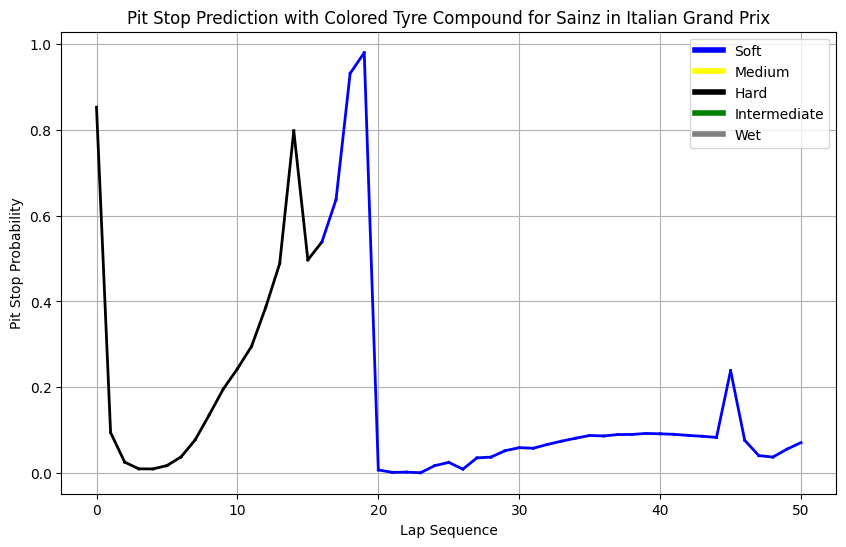

In [8]:
plt.figure(figsize=(10, 6))
for lap in range(1, len(pitstop_predictions[0])):
    start, end = lap - 1, lap
    color = compound_colors[compound_indices[start]]
    plt.plot([start, end], [pitstop_predictions[0][start], pitstop_predictions[0][end]], color=color, lw=2)

#plt.plot(sainz_data['PitstopFlag'].values, label='Actual Pit Stop Flag', color='black', linewidth=2)
plt.title("Pit Stop Prediction with Colored Tyre Compound for Sainz in Italian Grand Prix")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend(handles=[plt.Line2D([0], [0], color='blue', lw=4, label='Soft'),
                    plt.Line2D([0], [0], color='yellow', lw=4, label='Medium'),
                    plt.Line2D([0], [0], color='black', lw=4, label='Hard'),
                    plt.Line2D([0], [0], color='green', lw=4, label='Intermediate'),
                    plt.Line2D([0], [0], color='gray', lw=4, label='Wet')])
plt.grid(True)
plt.show()


Compound Model Accuracy: 0.74
Epoch 1/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.8023 - loss: 0.2246
Epoch 2/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9527 - loss: 0.0864
Epoch 3/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.9604 - loss: 0.0728
Epoch 4/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9644 - loss: 0.0639
Epoch 5/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - accuracy: 0.9641 - loss: 0.0634
Epoch 6/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9673 - loss: 0.0600
Epoch 7/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.9658 - loss: 0.0628
Epoch 8/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.9677 - loss: 0.0589
Epoch 9/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.9678 - loss: 0.0565
Epoch 10/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.9670 - loss: 0.0585
Epoch 11/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.9667 - loss: 0.0585


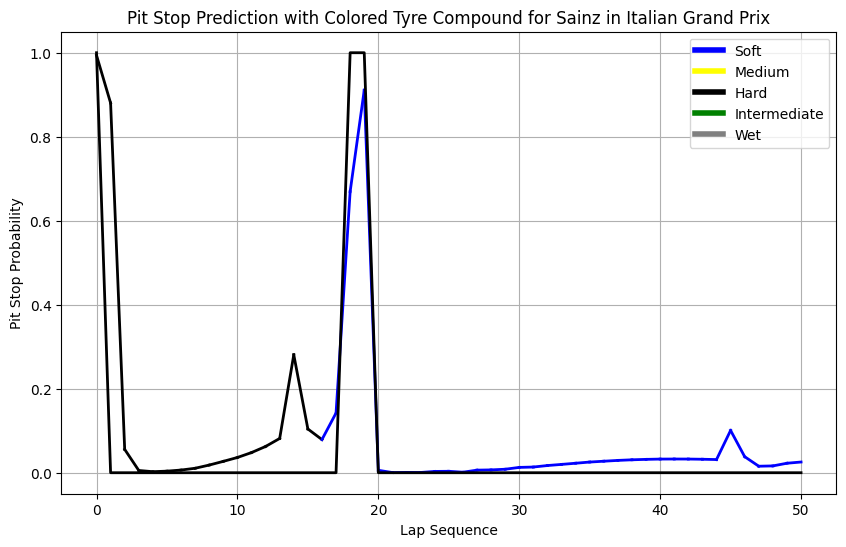

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Load dataset
file_path = '/kaggle/input/2023-races/2023_races.csv'
data = pd.read_csv(file_path)

# Define columns to keep
columns_to_keep = ['Driver', 'LapNumber', 'Team', 'PitInTime', 'PitOutTime', 'Race_Venue', 'Compound', 'Position', 'TyreLife', 'LapTime']
data_filtered = data[columns_to_keep]
data_filtered = data_filtered.dropna(subset=['LapTime'])  # Remove rows with missing LapTimes

# Convert time columns to seconds
time_columns = ['LapTime', 'PitInTime', 'PitOutTime']
for col in time_columns:
    data_filtered[col] = pd.to_timedelta(data_filtered[col], errors='coerce').dt.total_seconds()

# Handle missing Position data
data_filtered['Position'].replace('', np.nan, inplace=True)
data_filtered = data_filtered.groupby(['Race_Venue', 'Driver']).filter(lambda x: x['Position'].notna().all())

# Function to preprocess tyre life and set pit stop flags
def calculate_race_features(df):
    if df.empty:
        return df

    df = df.sort_values(by='LapNumber').reset_index(drop=True)
    total_laps = df['LapNumber'].max()
    
    # Race progress
    df['RaceProgress'] = df['LapNumber'] / total_laps

    # Normalize TyreLife using MinMaxScaler and reset on pit stops
    df['TyreLifeProgress'] = MinMaxScaler((0, 1)).fit_transform(df[['TyreLife']].fillna(0))
    for i in range(1, len(df)):
        if df.loc[i, 'PitInTime'] or df.loc[i, 'PitOutTime']:
            df.loc[i, 'TyreLifeProgress'] = 1.0  # Reset on pit stop

    # Normalize Position
    if df['Position'].notna().any():
        df['Position'] = MinMaxScaler((0, 1)).fit_transform(df[['Position']].fillna(0))
    else:
        df['Position'] = 0

    # Set PitstopFlag
    df['PitstopFlag'] = np.where((df['PitInTime'].notna()) | (df['PitOutTime'].notna()) | (df['LapNumber'] == 1), 1, 0)

    return df

# Apply feature engineering
data_filtered = data_filtered.groupby(['Race_Venue', 'Driver']).apply(calculate_race_features).reset_index(drop=True)

# Label encode 'Compound' to ensure consistency
compound_encoder = LabelEncoder()
data_filtered['Compound'] = compound_encoder.fit_transform(data_filtered['Compound'])

# Create OptimalCompound based on pit stops
data_filtered['OptimalCompound'] = data_filtered.apply(lambda row: row['Compound'] if row['PitstopFlag'] == 1 else np.nan, axis=1)
data_filtered['OptimalCompound'] = data_filtered['OptimalCompound'].fillna(-1).astype(int)

# Prepare the Compound Choice Model dataset
compound_data = data_filtered[['LapTime', 'TyreLifeProgress', 'RaceProgress', 'Position', 'Compound']].dropna()
X_compound = compound_data[['LapTime', 'TyreLifeProgress', 'RaceProgress', 'Position']]
y_compound = compound_data['Compound']
X_train_comp, X_test_comp, y_train_comp, y_test_comp = train_test_split(X_compound, y_compound, test_size=0.2, random_state=42)

# Train Compound Choice Model
compound_model = RandomForestClassifier()
compound_model.fit(X_train_comp, y_train_comp)
compound_accuracy = compound_model.score(X_test_comp, y_test_comp)
print(f"Compound Model Accuracy: {compound_accuracy:.2f}")

# Prepare the Pit Stop Model dataset
race_sequences, pitstop_labels = [], []
for _, race_data in data_filtered.groupby(['Race_Venue', 'Driver']):
    race_sequences.append(race_data[['LapNumber', 'TyreLifeProgress', 'RaceProgress', 'Position']].values)
    pitstop_labels.append(race_data['PitstopFlag'].values)

X_pitstop = pad_sequences(race_sequences, dtype='float32', padding='post', value=0)
y_pitstop = pad_sequences(pitstop_labels, dtype='float32', padding='post', value=0)

# Define and compile Pit Stop Model with class weights
class_weights = {0: 0.5, 1: 5.0}
input_layer = Input(shape=(None, X_pitstop.shape[2]))
x = LSTM(128, return_sequences=True)(input_layer)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
pitstop_output = Dense(1, activation='sigmoid', name='PitstopFlag')(x)

pitstop_model = Model(inputs=input_layer, outputs=pitstop_output)
pitstop_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
pitstop_model.fit(X_pitstop, y_pitstop, epochs=20, batch_size=1, callbacks=[early_stopping], class_weight=class_weights)

# Predict and plot for a specific race, e.g., SAI in Italian Grand Prix
sainz_data = data_filtered[(data_filtered['Driver'] == 'SAI') & (data_filtered['Race_Venue'] == 'Italian Grand Prix')]
sainz_data = calculate_race_features(sainz_data)
sainz_encoded = np.concatenate([sainz_data[['LapNumber', 'RaceProgress', 'TyreLifeProgress', 'Position']].values], axis=1)
sainz_padded = pad_sequences([sainz_encoded], dtype='float32', padding='post', value=0)

pitstop_predictions = pitstop_model.predict(sainz_padded)

# Plot pit stop probability with colored compound prediction
compound_colors = {0: 'blue', 1: 'yellow', 2: 'black', 3: 'green', 4: 'gray'}
compound_indices = compound_model.predict(X_compound)

plt.figure(figsize=(10, 6))
for lap in range(1, len(pitstop_predictions[0])):
    start, end = lap - 1, lap
    color = compound_colors[compound_indices[start]]
    plt.plot([start, end], [pitstop_predictions[0][start], pitstop_predictions[0][end]], color=color, lw=2)

plt.plot(sainz_data['PitstopFlag'].values, label='Actual Pit Stop Flag', color='black', linewidth=2)
plt.title("Pit Stop Prediction with Colored Tyre Compound for Sainz in Italian Grand Prix")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend(handles=[plt.Line2D([0], [0], color='blue', lw=4, label='Soft'),
                    plt.Line2D([0], [0], color='yellow', lw=4, label='Medium'),
                    plt.Line2D([0], [0], color='black', lw=4, label='Hard'),
                    plt.Line2D([0], [0], color='green', lw=4, label='Intermediate'),
                    plt.Line2D([0], [0], color='gray', lw=4, label='Wet')])
plt.grid(True)
plt.show()


Compound Model Accuracy: 0.68
Epoch 1/5
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 162s 158ms/step - accuracy: 0.9444 - loss: 0.2394
Epoch 2/5
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 153s 151ms/step - accuracy: 0.9934 - loss: 0.0249
Epoch 3/5
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 149s 148ms/step - accuracy: 0.9951 - loss: 0.0202
Epoch 4/5
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 140s 138ms/step - accuracy: 0.9959 - loss: 0.0171
Epoch 5/5
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 150s 149ms/step - accuracy: 0.9968 - loss: 0.0148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


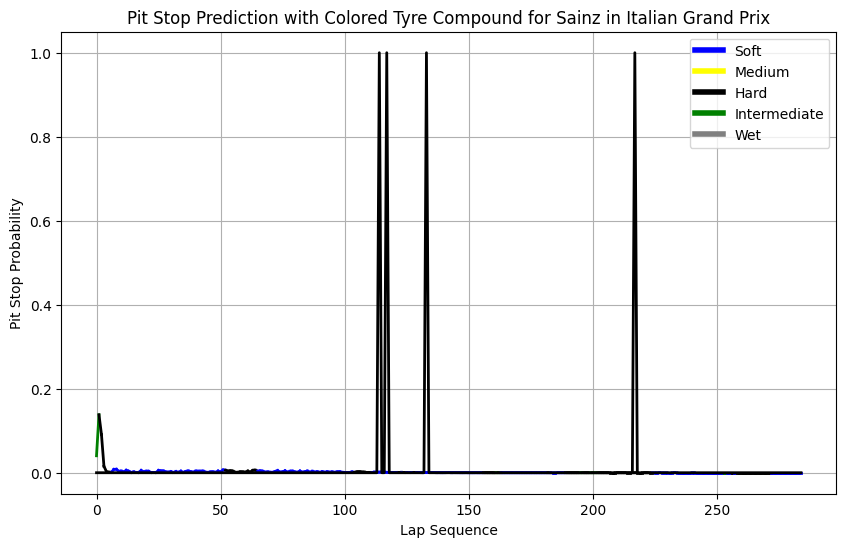

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Load the dataset
file_path = '/kaggle/input/2018-f1-data/f1_laps_data.csv'
data = pd.read_csv(file_path)

# Step 1: Split `Year_event` into `Year` and `Race_Venue`
data[['Year', 'Race_Venue']] = data['Year_Event'].str.split('_', expand=True)
data.drop(columns=['Year_Event'], inplace=True)  # Drop original column as it's now split

# Step 2: Remove rows with "Pre-season Testing" in `Race_Venue`
data = data[~data['Race_Venue'].str.contains('Pre-season Testing', case=False, na=False)]

# Step 3: Handle pit stop logic - Use `PitOutTime` only
data.drop(columns=['PitInTime'], inplace=True)
data['PitstopFlag'] = data['PitOutTime'].notna().astype(int)  # 1 for pit stop if `PitOutTime` exists

# Convert time columns to seconds for numerical consistency
time_columns = ['LapTime', 'PitOutTime']
for col in time_columns:
    data[col] = pd.to_timedelta(data[col], errors='coerce').dt.total_seconds()

# Step 4: Remove rows with missing LapTime data
data = data.dropna(subset=['LapTime'])

# Step 5: Feature Engineering
def calculate_race_features(df):
    if df.empty:
        return df

    df = df.sort_values(by='LapNumber').reset_index(drop=True)
    total_laps = df['LapNumber'].max()
    
    # Calculate RaceProgress
    df['RaceProgress'] = df['LapNumber'] / total_laps

    # Normalize TyreLife
    if df['TyreLife'].notna().any():
        df['TyreLifeProgress'] = MinMaxScaler((0, 1)).fit_transform(df[['TyreLife']].fillna(0))
    else:
        df['TyreLifeProgress'] = 0

    # Normalize Position
    if df['Position'].notna().any():
        df['Position'] = MinMaxScaler((0, 1)).fit_transform(df[['Position']].fillna(0))
    else:
        df['Position'] = 0

    return df

# Apply feature engineering
data = data.groupby(['Race_Venue', 'Driver']).apply(calculate_race_features).reset_index(drop=True)

# Encode compound types as numerical values for training
compound_encoder = LabelEncoder()
data['Compound'] = compound_encoder.fit_transform(data['Compound'])

# Creating a separate 'OptimalCompound' feature to use during pit stops
data['OptimalCompound'] = data.apply(lambda row: row['Compound'] if row['PitstopFlag'] == 1 else np.nan, axis=1)
data['OptimalCompound'] = data['OptimalCompound'].fillna(-1).astype(int)

# Prepare compound data for the compound model
compound_data = data[['LapTime', 'TyreLifeProgress', 'RaceProgress', 'Position', 'Compound']].dropna()
X_compound = compound_data[['LapTime', 'TyreLifeProgress', 'RaceProgress', 'Position']]
y_compound = compound_data['Compound']
X_train_comp, X_test_comp, y_train_comp, y_test_comp = train_test_split(X_compound, y_compound, test_size=0.2, random_state=42)

# Train compound choice model
compound_model = RandomForestClassifier()
compound_model.fit(X_train_comp, y_train_comp)
compound_accuracy = compound_model.score(X_test_comp, y_test_comp)
print(f"Compound Model Accuracy: {compound_accuracy:.2f}")

# Preparing the data for the pit stop model
race_sequences, pitstop_labels = [], []
for _, race_data in data.groupby(['Race_Venue', 'Driver']):
    race_sequences.append(race_data[['LapNumber', 'TyreLifeProgress', 'RaceProgress', 'Position']].values)
    pitstop_labels.append(race_data['PitstopFlag'].values)

X_pitstop = pad_sequences(race_sequences, dtype='float32', padding='post', value=0)
y_pitstop = pad_sequences(pitstop_labels, dtype='float32', padding='post', value=0)

# Define the pit stop model
class_weights = {0: 0.5, 1: 5.0}  # Emphasize pit stops
input_layer = Input(shape=(None, X_pitstop.shape[2]))

x = LSTM(128, return_sequences=True)(input_layer)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
pitstop_output = Dense(1, activation='sigmoid', name='PitstopFlag')(x)

pitstop_model = Model(inputs=input_layer, outputs=pitstop_output)
pitstop_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
history = pitstop_model.fit(X_pitstop, y_pitstop, epochs=5, batch_size=1, callbacks=[early_stopping], class_weight=class_weights)

# Testing and plotting for a specific driver in a specific race, e.g., "SAI" in "Italian Grand Prix"
sainz_data = data[(data['Driver'] == 'SAI') & (data['Race_Venue'] == 'Italian Grand Prix')]
sainz_data = calculate_race_features(sainz_data)
sainz_encoded = np.concatenate([sainz_data[['LapNumber', 'RaceProgress', 'TyreLifeProgress', 'Position']].values], axis=1)
sainz_padded = pad_sequences([sainz_encoded], dtype='float32', padding='post', value=0)

# Predict pit stops
pitstop_predictions = pitstop_model.predict(sainz_padded)

# Plot pit stop probability with colored compound prediction
compound_colors = {0: 'blue', 1: 'yellow', 2: 'black', 3: 'green', 4: 'gray'}  # 0=soft, 1=medium, 2=hard, 3=intermediate, 4=wet
# Generate compound predictions using probability-based argmax with a fallback for single-class output
compound_probabilities = compound_model.predict_proba(X_compound)

# If compound_probabilities is one-dimensional, it implies a single class
if compound_probabilities.ndim == 1:
    # Assign all indices to the same compound class, which could be 0 if Soft or other single class
    compound_indices = np.zeros_like(compound_probabilities, dtype=int)
else:
    # Use argmax as planned for multi-class
    compound_indices = np.argmax(compound_probabilities, axis=1)

# Proceed with plotting as before
plt.figure(figsize=(10, 6))

# Plot prediction with colored segments based on compounds
for lap in range(1, len(pitstop_predictions[0])):
    start = lap - 1
    end = lap
    color = compound_colors[compound_indices[start]]
    plt.plot([start, end], [pitstop_predictions[0][start], pitstop_predictions[0][end]], color=color, lw=2)

plt.plot(sainz_data['PitstopFlag'].values, label='Actual Pit Stop Flag', color='black', linewidth=2)
plt.title("Pit Stop Prediction with Colored Tyre Compound for Sainz in Italian Grand Prix")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend(handles=[plt.Line2D([0], [0], color='blue', lw=4, label='Soft'),
                    plt.Line2D([0], [0], color='yellow', lw=4, label='Medium'),
                    plt.Line2D([0], [0], color='black', lw=4, label='Hard'),
                    plt.Line2D([0], [0], color='green', lw=4, label='Intermediate'),
                    plt.Line2D([0], [0], color='gray', lw=4, label='Wet')])
plt.grid(True)
plt.show()


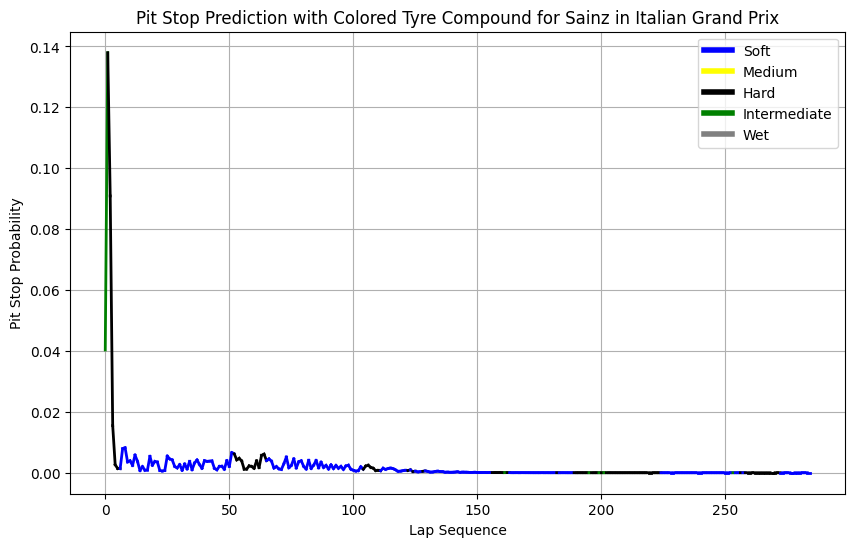

In [2]:
# Proceed with plotting as before
plt.figure(figsize=(10, 6))

# Plot prediction with colored segments based on compounds
for lap in range(1, len(pitstop_predictions[0])):
    start = lap - 1
    end = lap
    color = compound_colors[compound_indices[start]]
    plt.plot([start, end], [pitstop_predictions[0][start], pitstop_predictions[0][end]], color=color, lw=2)

#plt.plot(sainz_data['PitstopFlag'].values, label='Actual Pit Stop Flag', color='black', linewidth=2)
plt.title("Pit Stop Prediction with Colored Tyre Compound for Sainz in Italian Grand Prix")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend(handles=[plt.Line2D([0], [0], color='blue', lw=4, label='Soft'),
                    plt.Line2D([0], [0], color='yellow', lw=4, label='Medium'),
                    plt.Line2D([0], [0], color='black', lw=4, label='Hard'),
                    plt.Line2D([0], [0], color='green', lw=4, label='Intermediate'),
                    plt.Line2D([0], [0], color='gray', lw=4, label='Wet')])
plt.grid(True)
plt.show()


Compound Model Accuracy: 0.81
Epoch 1/5
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 156s 152ms/step - accuracy: 0.9440 - loss: 0.2487
Epoch 2/5
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 148s 146ms/step - accuracy: 0.9935 - loss: 0.0251
Epoch 3/5
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 155s 153ms/step - accuracy: 0.9947 - loss: 0.0203
Epoch 4/5
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 167s 166ms/step - accuracy: 0.9957 - loss: 0.0186
Epoch 5/5
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 171s 169ms/step - accuracy: 0.9967 - loss: 0.0149
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


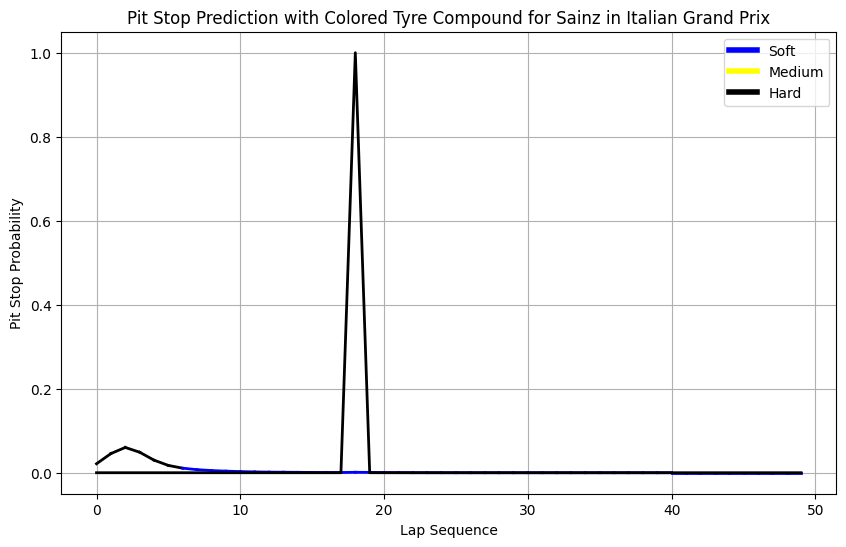

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Load the dataset
file_path = '/kaggle/input/2018-f1-data/f1_laps_data.csv'
data = pd.read_csv(file_path)

# Step 1: Split `Year_event` into `Year` and `Race_Venue`
data[['Year', 'Race_Venue']] = data['Year_Event'].str.split('_', expand=True)
data.drop(columns=['Year_Event'], inplace=True)  # Drop original column as it's now split

# Step 2: Remove rows with "Pre-season Testing" in `Race_Venue`
data = data[~data['Race_Venue'].str.contains('Pre-season Testing', case=False, na=False)]

# Step 3: Remove laps with 'Wet' and 'Intermediate' compounds
data = data[~data['Compound'].isin(['Wet', 'Intermediate'])]

# Step 4: Handle pit stop logic - Use `PitOutTime` only
data.drop(columns=['PitInTime'], inplace=True)
data['PitstopFlag'] = data['PitOutTime'].notna().astype(int)  # 1 for pit stop if `PitOutTime` exists

# Convert time columns to seconds for numerical consistency
time_columns = ['LapTime', 'PitOutTime']
for col in time_columns:
    data[col] = pd.to_timedelta(data[col], errors='coerce').dt.total_seconds()

# Step 5: Remove rows with missing LapTime data
data = data.dropna(subset=['LapTime'])

# Step 6: Feature Engineering
def calculate_race_features(df):
    if df.empty:
        return df

    df = df.sort_values(by='LapNumber').reset_index(drop=True)
    total_laps = df['LapNumber'].max()
    
    # Calculate RaceProgress
    df['RaceProgress'] = df['LapNumber'] / total_laps

    # Normalize TyreLife
    if df['TyreLife'].notna().any():
        df['TyreLifeProgress'] = MinMaxScaler((0, 1)).fit_transform(df[['TyreLife']].fillna(0))
    else:
        df['TyreLifeProgress'] = 0

    # Normalize Position
    if df['Position'].notna().any():
        df['Position'] = MinMaxScaler((0, 1)).fit_transform(df[['Position']].fillna(0))
    else:
        df['Position'] = 0

    return df

# Apply feature engineering
data = data.groupby(['Race_Venue', 'Driver']).apply(calculate_race_features).reset_index(drop=True)

# Encode compound types as numerical values for training
compound_encoder = LabelEncoder()
data['Compound'] = compound_encoder.fit_transform(data['Compound'])

# Creating a separate 'OptimalCompound' feature to use during pit stops
data['OptimalCompound'] = data.apply(lambda row: row['Compound'] if row['PitstopFlag'] == 1 else np.nan, axis=1)
data['OptimalCompound'] = data['OptimalCompound'].fillna(-1).astype(int)

# Filter compounds to only include 'Soft', 'Medium', and 'Hard'
compound_colors = {0: 'blue', 1: 'yellow', 2: 'black'}  # 0=soft, 1=medium, 2=hard
valid_compounds = [0, 1, 2]

# Prepare compound data for the compound model
compound_data = data[data['Compound'].isin(valid_compounds)][['LapTime', 'TyreLifeProgress', 'RaceProgress', 'Position', 'Compound']].dropna()
X_compound = compound_data[['LapTime', 'TyreLifeProgress', 'RaceProgress', 'Position']]
y_compound = compound_data['Compound']
X_train_comp, X_test_comp, y_train_comp, y_test_comp = train_test_split(X_compound, y_compound, test_size=0.2, random_state=42)

# Train compound choice model
compound_model = RandomForestClassifier()
compound_model.fit(X_train_comp, y_train_comp)
compound_accuracy = compound_model.score(X_test_comp, y_test_comp)
print(f"Compound Model Accuracy: {compound_accuracy:.2f}")

# Preparing the data for the pit stop model
race_sequences, pitstop_labels = [], []
for _, race_data in data.groupby(['Race_Venue', 'Driver']):
    race_sequences.append(race_data[['LapNumber', 'TyreLifeProgress', 'RaceProgress', 'Position']].values)
    pitstop_labels.append(race_data['PitstopFlag'].values)

X_pitstop = pad_sequences(race_sequences, dtype='float32', padding='post', value=0)
y_pitstop = pad_sequences(pitstop_labels, dtype='float32', padding='post', value=0)

# Define the pit stop model
class_weights = {0: 0.5, 1: 5.0}  # Emphasize pit stops
input_layer = Input(shape=(None, X_pitstop.shape[2]))

x = LSTM(128, return_sequences=True)(input_layer)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
pitstop_output = Dense(1, activation='sigmoid', name='PitstopFlag')(x)

pitstop_model = Model(inputs=input_layer, outputs=pitstop_output)
pitstop_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
history = pitstop_model.fit(X_pitstop, y_pitstop, epochs=5, batch_size=1, callbacks=[early_stopping], class_weight=class_weights)

# Testing and plotting for Sainz in the 2023 Italian Grand Prix
sainz_data = data[(data['Driver'] == 'SAI') & (data['Race_Venue'] == 'Italian Grand Prix') & (data['Year'] == '2023')]
sainz_data = calculate_race_features(sainz_data)
sainz_encoded = np.concatenate([sainz_data[['LapNumber', 'RaceProgress', 'TyreLifeProgress', 'Position']].values], axis=1)
sainz_padded = pad_sequences([sainz_encoded], dtype='float32', padding='post', value=0)

# Predict pit stops
pitstop_predictions = pitstop_model.predict(sainz_padded)

# Plot pit stop probability with colored compound prediction
compound_probabilities = compound_model.predict_proba(X_compound)
compound_indices = np.argmax(compound_probabilities, axis=1)

plt.figure(figsize=(10, 6))

# Plot prediction with colored segments based on compounds
for lap in range(1, len(pitstop_predictions[0])):
    start = lap - 1
    end = lap
    color = compound_colors.get(compound_indices[start], 'gray')  # Use 'gray' if compound is not found
    plt.plot([start, end], [pitstop_predictions[0][start], pitstop_predictions[0][end]], color=color, lw=2)

plt.plot(sainz_data['PitstopFlag'].values, label='Actual Pit Stop Flag', color='black', linewidth=2)
plt.title("Pit Stop Prediction with Colored Tyre Compound for Sainz in Italian Grand Prix")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend(handles=[plt.Line2D([0], [0], color='blue', lw=4, label='Soft'),
                    plt.Line2D([0], [0], color='yellow', lw=4, label='Medium'),
                    plt.Line2D([0], [0], color='black', lw=4, label='Hard')])
plt.grid(True)
plt.show()


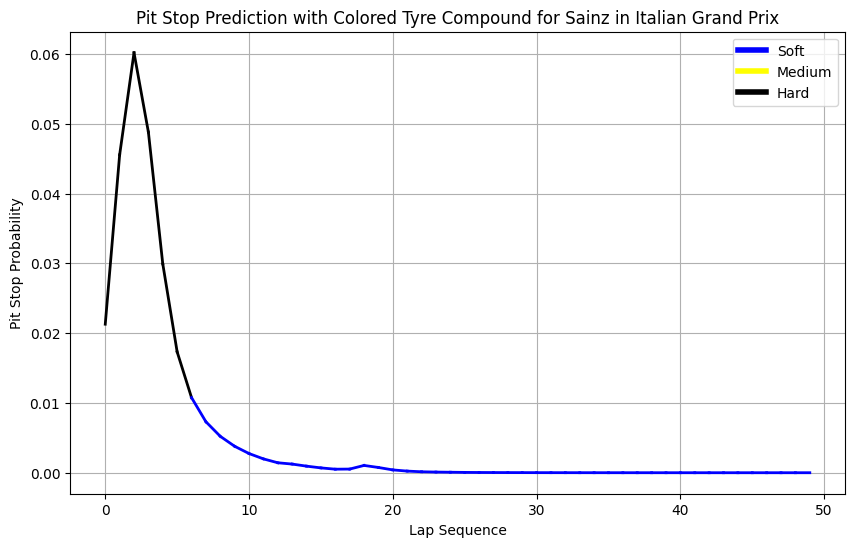

In [6]:
plt.figure(figsize=(10, 6))

# Plot prediction with colored segments based on compounds
for lap in range(1, len(pitstop_predictions[0])):
    start = lap - 1
    end = lap
    color = compound_colors.get(compound_indices[start], 'gray')  # Use 'gray' if compound is not found
    plt.plot([start, end], [pitstop_predictions[0][start], pitstop_predictions[0][end]], color=color, lw=2)

#plt.plot(sainz_data['PitstopFlag'].values, label='Actual Pit Stop Flag', color='black', linewidth=2)
plt.title("Pit Stop Prediction with Colored Tyre Compound for Sainz in Italian Grand Prix")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend(handles=[plt.Line2D([0], [0], color='blue', lw=4, label='Soft'),
                    plt.Line2D([0], [0], color='yellow', lw=4, label='Medium'),
                    plt.Line2D([0], [0], color='black', lw=4, label='Hard')])
plt.grid(True)
plt.show()

# Important code of our proven model starts from here Dhruv

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Load dataset
file_path = '/kaggle/input/filtered-data/f1_laps_data_filtered.csv'  # Update to correct path
data = pd.read_csv(file_path)
#data = data.dropna(subset=['LapTime'])
# 1. Split Year_Event into separate columns
data[['Year', 'Race_Venue']] = data['Year_Event'].str.split('_', expand=True)

# Define columns to keep based on available data
columns_to_keep = ['Driver', 'LapNumber', 'Team', 'PitInTime', 'PitOutTime', 'Year', 'Race_Venue', 'Compound', 'Position', 'TyreLife']
data_filtered = data[columns_to_keep]

# Handle missing Position data
data_filtered['Position'].replace('', np.nan, inplace=True)
data_filtered = data_filtered.groupby(['Year', 'Race_Venue', 'Driver']).filter(lambda x: x['Position'].notna().all())

# Feature engineering function (unchanged)
def calculate_race_features(df):
    if df.empty:
        return df  # Return empty DataFrame if no valid data

    total_laps = df['LapNumber'].max()
    driver_max_lap = df['LapNumber'].max()
    df['Crashed'] = 0
    if driver_max_lap < total_laps:
        df['Crashed'] = 1

    df['RaceProgress'] = df['LapNumber'] / total_laps
    df.dropna(subset=['RaceProgress'], inplace=True)
    df['TyreLifeProgress'] = MinMaxScaler((0, 1)).fit_transform(df[['TyreLife']].fillna(0))
    df['Position'] = MinMaxScaler((0, 1)).fit_transform(df[['Position']])
    df['PitstopFlag'] = np.where((df['PitInTime'].notna()) | (df['PitOutTime'].notna()), 1, 0)
    return df

# Apply feature calculations
train_data = data_filtered.groupby(['Year', 'Race_Venue', 'Driver']).apply(calculate_race_features).reset_index(drop=True)

# One-hot encode categorical features for Compound
categorical_cols = ['Compound']
onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats_train = onehot.fit_transform(train_data[categorical_cols])

# Prepare sequences
numerical_cols = ['LapNumber', 'RaceProgress', 'TyreLifeProgress', 'Position']
train_data_cleaned = np.concatenate([train_data[numerical_cols], encoded_cats_train], axis=1)
race_sequences, labels = [], []
for _, race_data in train_data.groupby(['Year', 'Race_Venue', 'Driver']):
    if not race_data.empty:
        race_data_combined = np.concatenate([race_data[numerical_cols].values, onehot.transform(race_data[categorical_cols])], axis=1)
        race_sequences.append(race_data_combined)
        labels.append(race_data['PitstopFlag'].values)

X_padded = pad_sequences(race_sequences, dtype='float32', padding='post', value=0)
y_padded = pad_sequences(labels, dtype='float32', padding='post', value=0)

# Define and compile model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(None, X_padded.shape[2])),
    Dropout(0.3),
    BatchNormalization(),
    Dense(64, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train and save the model as a .pkl file
model.fit(X_padded, y_padded, epochs=5, batch_size=1, callbacks=[early_stopping])
joblib.dump(model, 'pitstop_prediction_model.pkl')  # Save model
model.save('my_model.h5')


Epoch 1/5
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9623 - loss: 0.1867
Epoch 2/5
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9786 - loss: 0.0820
Epoch 3/5
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9801 - loss: 0.0742
Epoch 4/5
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9815 - loss: 0.0694
Epoch 5/5
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9809 - loss: 0.0681


In [13]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Load dataset
file_path = '/kaggle/input/2018-f1-data/f1_laps_data.csv'  # Update to correct path
data = pd.read_csv(file_path)

# Split Year_Event into separate columns
data[['Year', 'Race_Venue']] = data['Year_Event'].str.split('_', expand=True)

# Define columns to keep based on available data
columns_to_keep = ['Driver', 'LapNumber', 'Team', 'PitInTime', 'PitOutTime', 'Year', 'Compound', 'Race_Venue', 'Position', 'TyreLife']
data_filtered = data[columns_to_keep]

# Handle missing Position data
data_filtered['Position'].replace('', np.nan, inplace=True)
data_filtered = data_filtered.groupby(['Year', 'Race_Venue', 'Driver']).filter(lambda x: x['Position'].notna().all())

# Feature engineering function
def calculate_race_features(df):
    if df.empty:
        return df  # Return empty DataFrame if no valid data

    total_laps = df['LapNumber'].max()
    driver_max_lap = df['LapNumber'].max()
    df['Crashed'] = 0
    if driver_max_lap < total_laps:
        df['Crashed'] = 1

    df['RaceProgress'] = df['LapNumber'] / total_laps
    df.dropna(subset=['RaceProgress'], inplace=True)
    df['TyreLifeProgress'] = MinMaxScaler((0, 1)).fit_transform(df[['TyreLife']].fillna(0))
    df['Position'] = MinMaxScaler((0, 1)).fit_transform(df[['Position']])
    df['PitstopFlag'] = np.where((df['PitInTime'].notna()) | (df['PitOutTime'].notna()), 1, 0)
    return df

# Apply feature calculations
train_data = data_filtered.groupby(['Year', 'Race_Venue', 'Driver']).apply(calculate_race_features).reset_index(drop=True)

# One-hot encode categorical features for 'Team' and 'Compound'
categorical_cols = ['Team', 'Compound']
onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats_train = onehot.fit_transform(train_data[categorical_cols])

# Prepare sequences with numerical features and encoded categorical features
numerical_cols = ['LapNumber', 'RaceProgress', 'TyreLifeProgress', 'Position']
train_data_cleaned = np.concatenate([train_data[numerical_cols], encoded_cats_train], axis=1)

race_sequences, labels = [], []
for _, race_data in train_data.groupby(['Year', 'Race_Venue', 'Driver']):
    if not race_data.empty:
        race_data_combined = np.concatenate([race_data[numerical_cols].values, onehot.transform(race_data[categorical_cols])], axis=1)
        race_sequences.append(race_data_combined)
        labels.append(race_data['PitstopFlag'].values)

X_padded = pad_sequences(race_sequences, dtype='float32', padding='post', value=0)
y_padded = pad_sequences(labels, dtype='float32', padding='post', value=0)

# Define and compile model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(None, X_padded.shape[2])),
    Dropout(0.3),
    BatchNormalization(),
    Dense(64, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train and save the model as a .pkl file
model.fit(X_padded, y_padded, epochs=200, batch_size=1, callbacks=[early_stopping])
joblib.dump(model, 'pitstop_prediction_model.pkl')  # Save model
model.save('my_model.h5')


Epoch 1/200
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9520 - loss: 0.2035
Epoch 2/200
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9782 - loss: 0.0836
Epoch 3/200
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9804 - loss: 0.0710
Epoch 4/200
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9803 - loss: 0.0687
Epoch 5/200
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9819 - loss: 0.0641
Epoch 6/200
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9828 - loss: 0.0602
Epoch 7/200
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9820 - loss: 0.0614
Epoch 8/200
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9836 - loss: 0.0570
Epoch 9/200
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9842 - loss: 0.0559
Epoch 10/200
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9835 - loss: 0.0565
Epoch 11/200
2151/2151 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9848 - loss: 0.0526
Epoch 12

In [ ]:
model.save('prediction_model')

In [ ]:
data_filtered

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


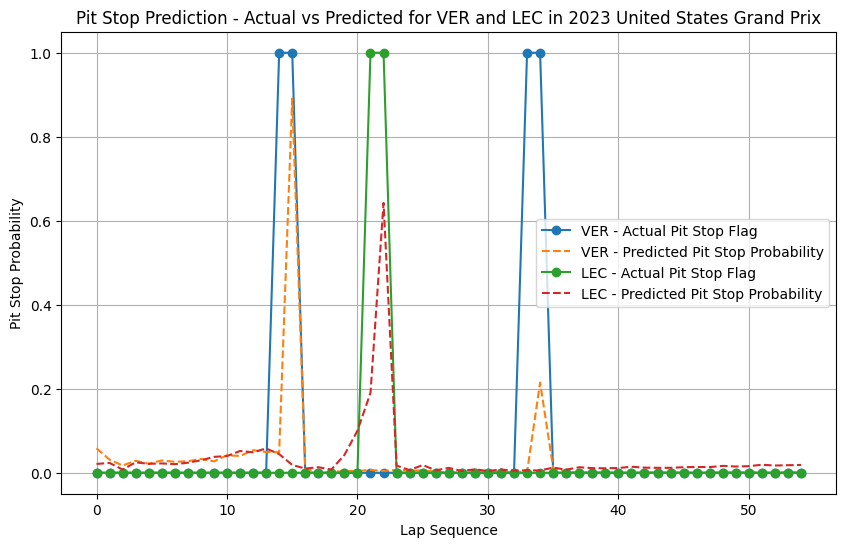

In [2]:
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load the pre-trained model
loaded_model = joblib.load('/kaggle/working/pitstop_prediction_model.pkl')

# Filter data for VER and LEC in the 2023 United States Grand Prix
us_2023_data = data_filtered[(data_filtered['Year'] == '2023') & 
                             (data_filtered['Race_Venue'] == 'United States Grand Prix') & 
                             (data_filtered['Driver'].isin(['VER', 'LEC']))]

# Feature engineering for the United States 2023 data
us_2023_data = calculate_race_features(us_2023_data)

# Prepare and make predictions for each driver
predictions = {}
for driver in ['VER', 'LEC']:
    driver_data = us_2023_data[us_2023_data['Driver'] == driver]
    if driver_data.empty:
        print(f"No data available for {driver} in the 2023 United States Grand Prix.")
        continue

    # Ensure both 'Team' and 'Compound' are one-hot encoded consistently
    driver_data_encoded = onehot.transform(driver_data[['Team', 'Compound']])
    
    # Combine numerical and encoded features
    driver_data_combined = np.concatenate([driver_data[numerical_cols].values, driver_data_encoded], axis=1)

    # Pad the sequence
    driver_padded = pad_sequences([driver_data_combined], dtype='float32', padding='post', value=0)

    # Make predictions and store them
    predictions[driver] = {
        'actual': driver_data['PitstopFlag'].values,
        'predicted': loaded_model.predict(driver_padded)[0]  # Prediction for each lap
    }

# Plot the actual vs. predicted results
plt.figure(figsize=(10, 6))
for driver, data in predictions.items():
    plt.plot(data['actual'], label=f'{driver} - Actual Pit Stop Flag', marker='o')
    plt.plot(data['predicted'], label=f'{driver} - Predicted Pit Stop Probability', linestyle='--')

plt.title("Pit Stop Prediction - Actual vs Predicted for VER and LEC in 2023 United States Grand Prix")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend()
plt.grid(True)
plt.show()


In [4]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Load dataset
file_path = '/kaggle/input/2018-f1-data/f1_laps_data.csv'  # Update to correct path
data = pd.read_csv(file_path)

# Split Year_Event into separate columns
data[['Year', 'Race_Venue']] = data['Year_Event'].str.split('_', expand=True)

# Define columns to keep based on available data
columns_to_keep = ['Driver', 'LapNumber', 'Team', 'PitInTime', 'PitOutTime', 'Year', 'Compound', 'Race_Venue', 'Position', 'TyreLife', 'LapStartTime', 'TrackStatus', 'LapTime']
data_filtered = data[columns_to_keep]

# Remove rows where Compound or LapTime is NaN
data_filtered.dropna(subset=['Compound', 'LapTime'], inplace=True)

# Process TrackStatus: set values > 7 to 1 and remove null values
data_filtered['TrackStatus'] = pd.to_numeric(data_filtered['TrackStatus'], errors='coerce')
data_filtered['TrackStatus'] = np.where(data_filtered['TrackStatus'] > 7, 1, data_filtered['TrackStatus'])
data_filtered.dropna(subset=['TrackStatus'], inplace=True)

# Convert LapStartTime to timedelta
data_filtered['LapStartTime'] = pd.to_timedelta(data_filtered['LapStartTime'])

# Calculate GapToDriverAhead
data_filtered.sort_values(by=['LapNumber', 'Position'], inplace=True)
data_filtered['GapToDriverAhead'] = np.nan
for lap in data_filtered['LapNumber'].unique():
    lap_data = data_filtered[data_filtered['LapNumber'] == lap]
    for idx in range(1, len(lap_data)):
        current_driver_time = lap_data.iloc[idx]['LapStartTime']
        driver_ahead_time = lap_data.iloc[idx - 1]['LapStartTime']
        gap = (current_driver_time - driver_ahead_time).total_seconds()
        data_filtered.loc[lap_data.index[idx], 'GapToDriverAhead'] = gap
data_filtered.loc[data_filtered['Position'] == 1, 'GapToDriverAhead'] = 0

# Handle missing Position data
data_filtered['Position'].replace('', np.nan, inplace=True)
data_filtered = data_filtered.groupby(['Year', 'Race_Venue', 'Driver']).filter(lambda x: x['Position'].notna().all())

# Feature engineering function
def calculate_race_features(df):
    if df.empty:
        return df  # Return empty DataFrame if no valid data

    total_laps = df['LapNumber'].max()
    driver_max_lap = df['LapNumber'].max()
    df['Crashed'] = 0
    if driver_max_lap < total_laps:
        df['Crashed'] = 1

    df['RaceProgress'] = df['LapNumber'] / total_laps
    df.dropna(subset=['RaceProgress'], inplace=True)
    df['TyreLifeProgress'] = MinMaxScaler((0, 1)).fit_transform(df[['TyreLife']].fillna(0))
    df['Position'] = MinMaxScaler((0, 1)).fit_transform(df[['Position']])
    df['PitstopFlag'] = np.where((df['PitInTime'].notna()) | (df['PitOutTime'].notna()), 1, 0)
    return df

# Apply feature calculations
train_data = data_filtered.groupby(['Year', 'Race_Venue', 'Driver']).apply(calculate_race_features).reset_index(drop=True)

# One-hot encode categorical features for 'Team' and 'Compound'
categorical_cols = ['Team', 'Compound']
onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats_train = onehot.fit_transform(train_data[categorical_cols])

# Prepare sequences with numerical features and encoded categorical features
numerical_cols = ['LapNumber', 'RaceProgress', 'TyreLifeProgress', 'Position', 'GapToDriverAhead']
train_data_cleaned = np.concatenate([train_data[numerical_cols], encoded_cats_train], axis=1)

race_sequences, labels = [], []
for _, race_data in train_data.groupby(['Year', 'Race_Venue', 'Driver']):
    if not race_data.empty:
        race_data_combined = np.concatenate([race_data[numerical_cols].values, onehot.transform(race_data[categorical_cols])], axis=1)
        race_sequences.append(race_data_combined)
        labels.append(race_data['PitstopFlag'].values)

X_padded = pad_sequences(race_sequences, dtype='float32', padding='post', value=0)
y_padded = pad_sequences(labels, dtype='float32', padding='post', value=0)

# Define and compile model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(None, X_padded.shape[2])),
    Dropout(0.3),
    BatchNormalization(),
    Dense(64, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train and save the model
model.fit(X_padded, y_padded, epochs=200, batch_size=1, callbacks=[early_stopping])
joblib.dump(model, 'pitstop_prediction_model.pkl')  # Save model

Epoch 1/200
2237/2237 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9400 - loss: 0.2433
Epoch 2/200
2237/2237 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9662 - loss: 0.1376
Epoch 3/200
2237/2237 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9657 - loss: 0.1349
Epoch 4/200
2237/2237 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9658 - loss: 0.1339
Epoch 5/200
2237/2237 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9669 - loss: 0.1281
Epoch 6/200
2237/2237 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9669 - loss: 0.1267
Epoch 7/200
2237/2237 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9699 - loss: 0.1144
Epoch 8/200
2237/2237 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9705 - loss: 0.1130
Epoch 9/200
2237/2237 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9703 - loss: 0.1129
Epoch 10/200
2237/2237 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9713 - loss: 0.1091
Epoch 11/200
2237/2237 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9726 - loss: 0.1049
Epoch 12

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Load dataset
file_path = '/kaggle/input/2018-f1-data/f1_laps_data.csv'  # Update to correct path
data = pd.read_csv(file_path)

# Split 'Year_Event' into separate columns for 'Year' and 'Race_Venue'
data[['Year', 'Race_Venue']] = data['Year_Event'].str.split('_', expand=True)

# Define columns to keep
columns_to_keep = ['Driver', 'LapNumber', 'Team', 'PitInTime', 'PitOutTime', 'Year', 'Compound', 'Race_Venue', 
                   'Position', 'TyreLife', 'LapStartTime', 'TrackStatus', 'LapTime']
data_filtered = data[columns_to_keep]

# Remove rows where Compound or LapTime is NaN
data_filtered.dropna(subset=['Compound', 'LapTime'], inplace=True)

# Process TrackStatus: set values > 7 to 1 and remove null values
data_filtered['TrackStatus'] = pd.to_numeric(data_filtered['TrackStatus'], errors='coerce')
data_filtered['TrackStatus'] = np.where(data_filtered['TrackStatus'] > 7, 1, data_filtered['TrackStatus'])
data_filtered.dropna(subset=['TrackStatus'], inplace=True)

# Convert LapStartTime to timedelta
data_filtered['LapStartTime'] = pd.to_timedelta(data_filtered['LapStartTime'])

# Calculate GapToDriverAhead
data_filtered.sort_values(by=['LapNumber', 'Position'], inplace=True)
data_filtered['GapToDriverAhead'] = np.nan
for lap in data_filtered['LapNumber'].unique():
    lap_data = data_filtered[data_filtered['LapNumber'] == lap]
    for idx in range(1, len(lap_data)):
        current_driver_time = lap_data.iloc[idx]['LapStartTime']
        driver_ahead_time = lap_data.iloc[idx - 1]['LapStartTime']
        gap = (current_driver_time - driver_ahead_time).total_seconds()
        data_filtered.loc[lap_data.index[idx], 'GapToDriverAhead'] = gap
data_filtered.loc[data_filtered['Position'] == 1, 'GapToDriverAhead'] = 0

# Calculate GapToDriverBehind
data_filtered['GapToDriverBehind'] = np.nan
for lap in data_filtered['LapNumber'].unique():
    lap_data = data_filtered[data_filtered['LapNumber'] == lap].sort_values(by='Position', ascending=False)
    for idx in range(1, len(lap_data)):
        current_driver_time = lap_data.iloc[idx]['LapStartTime']
        driver_behind_time = lap_data.iloc[idx - 1]['LapStartTime']
        gap = (driver_behind_time - current_driver_time).total_seconds()
        data_filtered.loc[lap_data.index[idx], 'GapToDriverBehind'] = gap
data_filtered.loc[data_filtered['Position'] == data_filtered['Position'].max(), 'GapToDriverBehind'] = 0

# Feature engineering function
def calculate_race_features(df):
    total_laps = df['LapNumber'].max()
    df['RaceProgress'] = df['LapNumber'] / total_laps
    df['TyreLifeProgress'] = MinMaxScaler((0, 1)).fit_transform(df[['TyreLife']].fillna(0))
    df['Position'] = MinMaxScaler((0, 1)).fit_transform(df[['Position']])
    df['PitstopFlag'] = np.where((df['PitInTime'].notna()) | (df['PitOutTime'].notna()), 1, 0)
    
    # Additional Features
    compounds_used = df['Compound'].nunique()
    df['TwoTyreCompoundsUsed'] = compounds_used >= 2

    # Laps Until Next Pitstop
    df['LapsUntilNextPitstop'] = df['LapNumber'].diff().fillna(0).cumsum()
    pit_lap_indices = df[df['PitstopFlag'] == 1].index
    for i, idx in enumerate(pit_lap_indices):
        if i < len(pit_lap_indices) - 1:
            next_pit_lap = df.loc[pit_lap_indices[i + 1], 'LapNumber']
            df.loc[idx:pit_lap_indices[i + 1], 'LapsUntilNextPitstop'] = next_pit_lap - df.loc[idx:pit_lap_indices[i + 1], 'LapNumber']

    # Drivers Close on Track
    df['CloseAhead'] = df['GapToDriverAhead'] <= 2
    df['CloseBehind'] = df['GapToDriverBehind'] <= 2
    df['CarClose'] = df['CloseAhead'] | df['CloseBehind']

    # PitStopBehind
    df['PitStopBehind'] = ((df['CloseBehind'] == True) & (df['PitstopFlag'].shift(-1) == 1)).astype(int)

    # TrackStatus cleanup
    df = df.dropna(subset=['TrackStatus'])
    df['TrackStatus'] = np.where(df['TrackStatus'] >= 7, 1, df['TrackStatus'])
    return df

# Apply feature calculations
train_data = data_filtered.groupby(['Year', 'Race_Venue', 'Driver']).apply(calculate_race_features).reset_index(drop=True)

# One-hot encode categorical features for 'Team' and 'Compound'
categorical_cols = ['Team', 'Compound']
onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats_train = onehot.fit_transform(train_data[categorical_cols])

# Prepare sequences with numerical features and encoded categorical features
numerical_cols = ['LapNumber', 'RaceProgress', 'TyreLifeProgress', 'Position', 'GapToDriverAhead', 'GapToDriverBehind', 'CloseAhead', 'CloseBehind', 'CarClose', 'PitStopBehind']
train_data_cleaned = np.concatenate([train_data[numerical_cols], encoded_cats_train], axis=1)

# Prepare training sequences and labels
race_sequences, labels = [], []
for _, race_data in train_data.groupby(['Year', 'Race_Venue', 'Driver']):
    race_data_combined = np.concatenate([race_data[numerical_cols].values, onehot.transform(race_data[categorical_cols])], axis=1)
    race_sequences.append(race_data_combined)
    labels.append(race_data['PitstopFlag'].values)

X_padded = pad_sequences(race_sequences, dtype='float32', padding='post', value=0)
y_padded = pad_sequences(labels, dtype='float32', padding='post', value=0)

# Define class weights
class_weights = {0: 1, 1: 21}

# Define and compile the model with specified hyperparameters
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(None, X_padded.shape[2])),
    Dropout(0.3),
    BatchNormalization(),
    Dense(64, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train and save the model
model.fit(X_padded, y_padded, epochs=200, batch_size=1, class_weight=class_weights, callbacks=[early_stopping], validation_split=0.2)
joblib.dump(model, 'pitstop_prediction_model.pkl')  # Save model

Epoch 1/200
1789/1789 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9311 - loss: nan - val_accuracy: 0.9641 - val_loss: nan
Epoch 2/200
1789/1789 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9665 - loss: nan - val_accuracy: 0.9641 - val_loss: nan
Epoch 3/200
1789/1789 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9670 - loss: nan - val_accuracy: 0.9641 - val_loss: nan
Epoch 4/200
1789/1789 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9666 - loss: nan - val_accuracy: 0.9641 - val_loss: nan
Epoch 5/200
1789/1789 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9667 - loss: nan - val_accuracy: 0.9641 - val_loss: nan


['pitstop_prediction_model.pkl']

In [ ]:
import joblib

joblib.dump(model, 'pitstop_prediction_model.pkl')  # Save model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


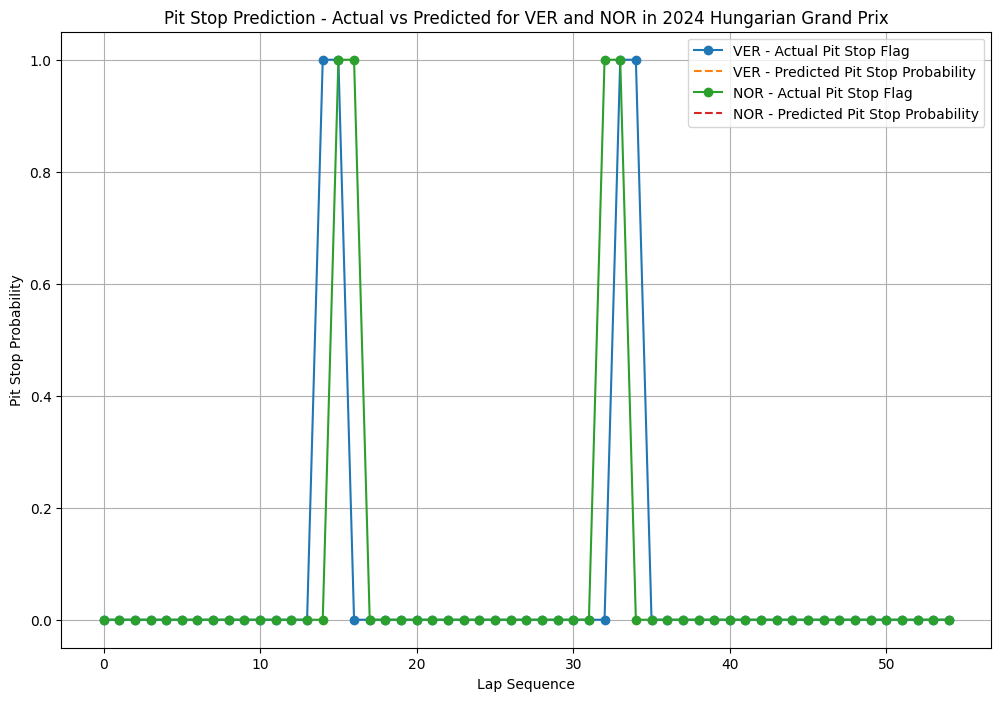

In [5]:
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load the pre-trained model
loaded_model = joblib.load('/kaggle/working/pitstop_prediction_model.pkl')


# Filter data for VER and NOR in the 2024 Hungarian Grand Prix
hungary_2024_data = data_filtered[(data_filtered['Year'] == '2023') & 
                                  (data_filtered['Race_Venue'] == 'United States Grand Prix') & 
                                  (data_filtered['Driver'].isin(['VER', 'NOR']))]

# Apply feature engineering for the Hungarian 2024 data
hungary_2024_data = hungary_2024_data.groupby(['Year', 'Race_Venue', 'Driver'], group_keys=False).apply(calculate_race_features)

# Prepare and make predictions for each driver
predictions = {}
for driver in ['VER', 'NOR']:
    driver_data = hungary_2024_data[hungary_2024_data['Driver'] == driver]
    if driver_data.empty:
        print(f"No data available for {driver} in the 2024 Hungarian Grand Prix.")
        continue

    # One-hot encode 'Team' and 'Compound' features
    driver_data_encoded = onehot.transform(driver_data[['Team', 'Compound']])
    
    # Combine numerical and encoded features
    driver_data_combined = np.concatenate([driver_data[numerical_cols].values, driver_data_encoded], axis=1)

    # Pad the sequence
    driver_padded = pad_sequences([driver_data_combined], dtype='float32', padding='post', value=0)

    # Make predictions
    predictions[driver] = {
        'actual': driver_data['PitstopFlag'].values,
        'predicted': loaded_model.predict(driver_padded)[0].flatten()  # Flatten to match sequence length
    }

# Plot the actual vs. predicted results
plt.figure(figsize=(12, 8))
for driver, data in predictions.items():
    plt.plot(data['actual'], label=f'{driver} - Actual Pit Stop Flag', marker='o')
    plt.plot(data['predicted'], label=f'{driver} - Predicted Pit Stop Probability', linestyle='--')

plt.title("Pit Stop Prediction - Actual vs Predicted for VER and NOR in 2024 Hungarian Grand Prix")
plt.xlabel("Lap Sequence")
plt.ylabel("Pit Stop Probability")
plt.legend()
plt.grid(True)
plt.show()
